# Agent 1 — Event-to-Action Recognition (OpenTheChests)

##### **Authors**: François-Xavier Morel - Mathieu Delarue - Laury Magne - Robin Guiavarch


#### **Summary**

Welcome to the notebook dedicated to **Agent 1: Event-to-Action Recognition** using the *OpenTheChests* environment.  
This notebook explores three progressively complex approaches to mapping event sequences to actions using reinforcement learning.


#### 📚 **Table of Contents**

🔹 **1. Simple Approach: One-to-One Event Mapping**


🔹 **2. Intermediate Approach: Temporal Window**


🔹 **3. Advanced Approach: Sequence Modeling**


#### 🧾 Project Overview

This notebook is part of the project **"Reinforcement Learning for Robotic Task Recognition in Event-Driven Environments"**.  
It focuses on **Agent 1**, whose goal is to learn how to recognize meaningful patterns in a stream of symbolic events and decide which chest to open in the environment called **OpenTheChests**.

#### 🎯 Objective

Agent 1 must learn to:
- Observe a continuous stream of symbolic events (e.g., A, B, C...)
- Recognize valid event patterns (with or without noise)
- Map those patterns to the correct action (i.e., open the right chest)

The agent is trained using **Reinforcement Learning (RL)**, with several architectures and levels of complexity explored in this notebook:
1. **Simple Mapping** (Single event → Action)
2. **Temporal Window** (Short sequences of events)
3. **Advanced Sequence Modeling** (LSTM, Transformer)

#### 🧪 Environments & Tools

The experiments rely on:
- Custom Gym environments (`OpenTheChests-v0`, `v1`, `v2`)
- Stable baseline 3
- Evaluation metrics: **average reward**, **success rate**, **learning curves**


📌 Follow the notebook sections in order to visualize events, train, and evaluate the models step by step.


In [1]:
# Patch for numpy.bool8 removal in NumPy >= 1.24
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from pathlib import Path
import sys, os

# locate the directory that actually contains your package
PROJECT_ROOT = Path("/Users/robinguiavarch/Documents/git_projects/robot_task_recognition_rl").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print("✅  Added:", PROJECT_ROOT)


✅  Added: /Users/robinguiavarch/Documents/git_projects/robot_task_recognition_rl


## 1. Simple Approach: One-to-One Event Mapping




### 1.1. Event Visualization



In [8]:
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs

register_custom_envs()


In [9]:
import gym
print("✅ Is OpenTheChests-v0 registered?", "OpenTheChests-v0" in gym.envs.registry)

✅ Is OpenTheChests-v0 registered? True


/Users/robinguiavarch/Library/Caches/pypoetry/virtualenvs/robot-task-recognition-rl-5EzxE_ra-py3.13/lib/python3.13/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


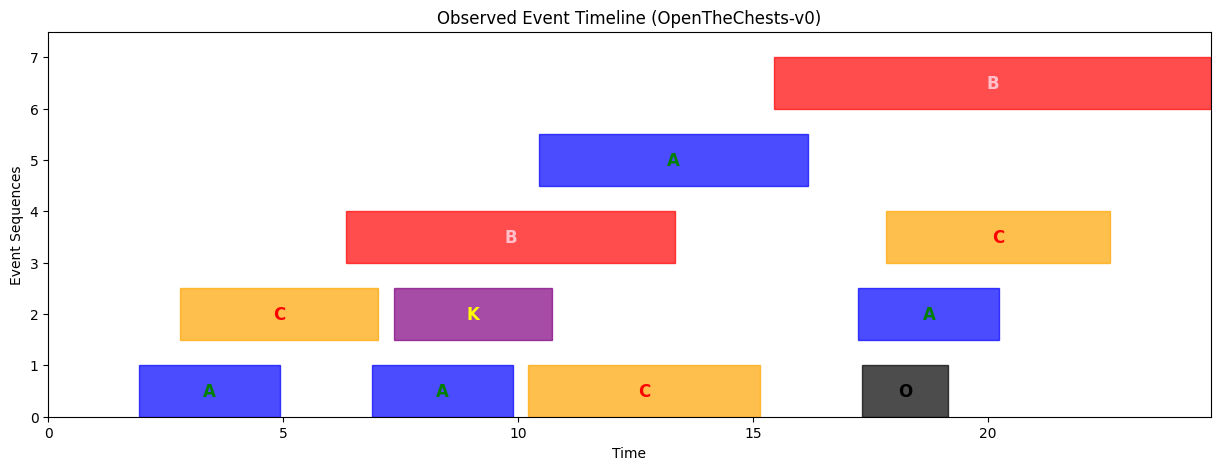

In [10]:
from agent1_patterns_chests_to_reach.utils.visualization import visualize_env_timeline

visualize_env_timeline("OpenTheChests-v0", num_steps=10)


### 1.2. Actor-Critic




###### Actor-Critic Pipeline for `OpenTheChests-v0`

**Overview**

This Actor-Critic architecture uses a **Q-value based critic** instead of a state-value function. The agent learns:

- a stochastic policy $\pi(a_t \mid s_t)$ (actor),
- a Q-value estimator $Q(s_t, a_t)$ (critic).

---

**Inputs and Outputs**

- **Input:** state vector $s_t \in \mathbb{R}^{33}$  
- **Actor output:** action probabilities $\pi(a_t \mid s_t)$ over 8 discrete actions  
- **Critic output:** estimated Q-values $Q(s_t, a)$ for all $a \in \{0, ..., 7\}$

---

**Actor Network**

A two-layer MLP outputs a softmax distribution over actions:

$$
\pi(a \mid s_t) = \text{Softmax}(W_2 \cdot \text{ReLU}(W_1 \cdot s_t + b_1) + b_2)
$$

Actions are sampled (or greedily selected) from this distribution during rollout.

---

**Critic Network**

The critic estimates Q-values for each action:

$$
Q(s_t, a) = \text{Linear}(\text{ReLU}(\text{Linear}(s_t)))
$$

This produces an 8-dimensional vector $Q(s_t, \cdot)$.

---

**Action Sampling and Log-Probabilities**

During interaction with the environment, the actor samples an action:

$$
a_t \sim \pi(\cdot \mid s_t)
$$

and stores the log-probability $\log \pi(a_t \mid s_t)$ for policy gradient computation.

---

**Critic Loss (TD regression)**

The critic is trained to regress toward TD targets:

$$
y_t = r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a')
$$

Critic loss:

$$
\mathcal{L}_{\text{critic}} = \frac{1}{T} \sum_{t=0}^{T-1} \left( Q(s_t, a_t) - y_t \right)^2
$$

---

**Actor Loss (Advantage Policy Gradient)**

We compute the **advantage** as:

$$
A_t = y_t - Q(s_t, a_t)
$$

Actor loss:

$$
\mathcal{L}_{\text{actor}} = - \frac{1}{T} \sum_{t=0}^{T-1} \log \pi(a_t \mid s_t) \cdot A_t
$$

---

**Training Summary**

- Actor improves policy by maximizing advantage.
- Critic regresses toward target Q-values using TD(0).
- Both networks are updated via gradient descent on their respective losses.



Training with gamma: 0.1
[Ep 50] Actor Loss: 1.0873, Critic Loss: 1.4821 | EvalR: -94.84 | Success: 0.0%
[Ep 100] Actor Loss: -0.9438, Critic Loss: 1.0442 | EvalR: 0.78 | Success: 8.0%
[Ep 150] Actor Loss: -0.5591, Critic Loss: 1.8050 | EvalR: 2.48 | Success: 52.0%
[Ep 200] Actor Loss: -1.4920, Critic Loss: 1.5569 | EvalR: 2.62 | Success: 64.0%
[Ep 250] Actor Loss: -0.1162, Critic Loss: 0.6081 | EvalR: 2.72 | Success: 76.0%
[Ep 300] Actor Loss: 0.2612, Critic Loss: 0.0865 | EvalR: 2.50 | Success: 62.0%
[Ep 350] Actor Loss: -0.1624, Critic Loss: 0.1057 | EvalR: 2.04 | Success: 52.0%
[Ep 400] Actor Loss: -0.4416, Critic Loss: 0.5043 | EvalR: 2.08 | Success: 46.0%
[Ep 450] Actor Loss: -0.2054, Critic Loss: 0.3353 | EvalR: 1.82 | Success: 46.0%
[Ep 500] Actor Loss: 0.0385, Critic Loss: 0.1349 | EvalR: 1.70 | Success: 18.0%
[Ep 550] Actor Loss: 0.1188, Critic Loss: 0.0305 | EvalR: -0.02 | Success: 0.0%
[Ep 600] Actor Loss: -1.2468, Critic Loss: 0.5670 | EvalR: 0.76 | Success: 0.0%
[Ep 650] 

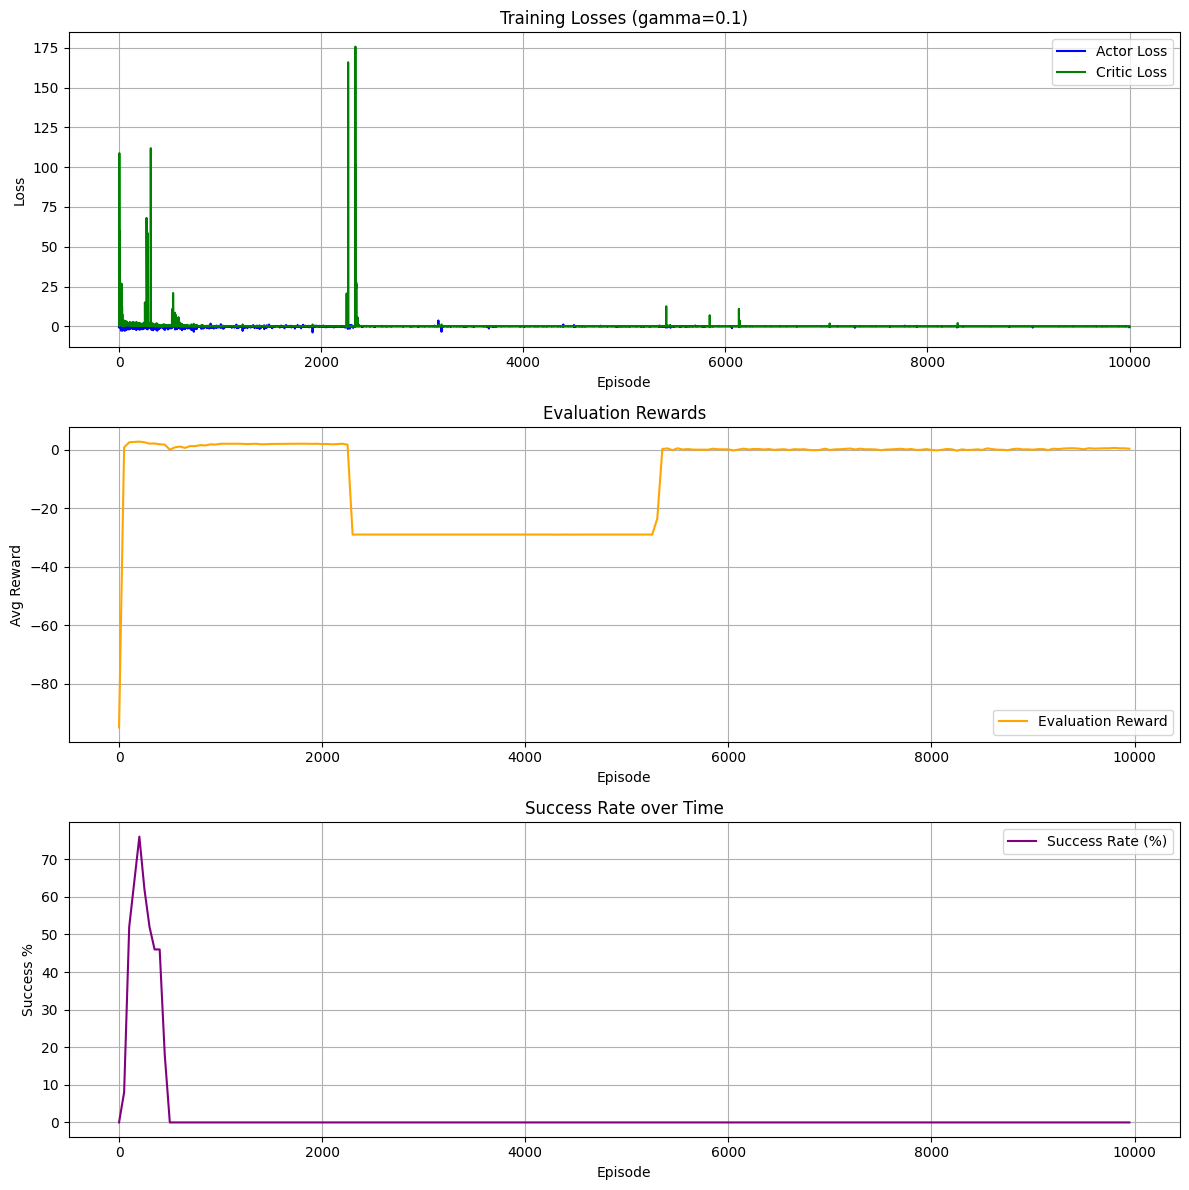

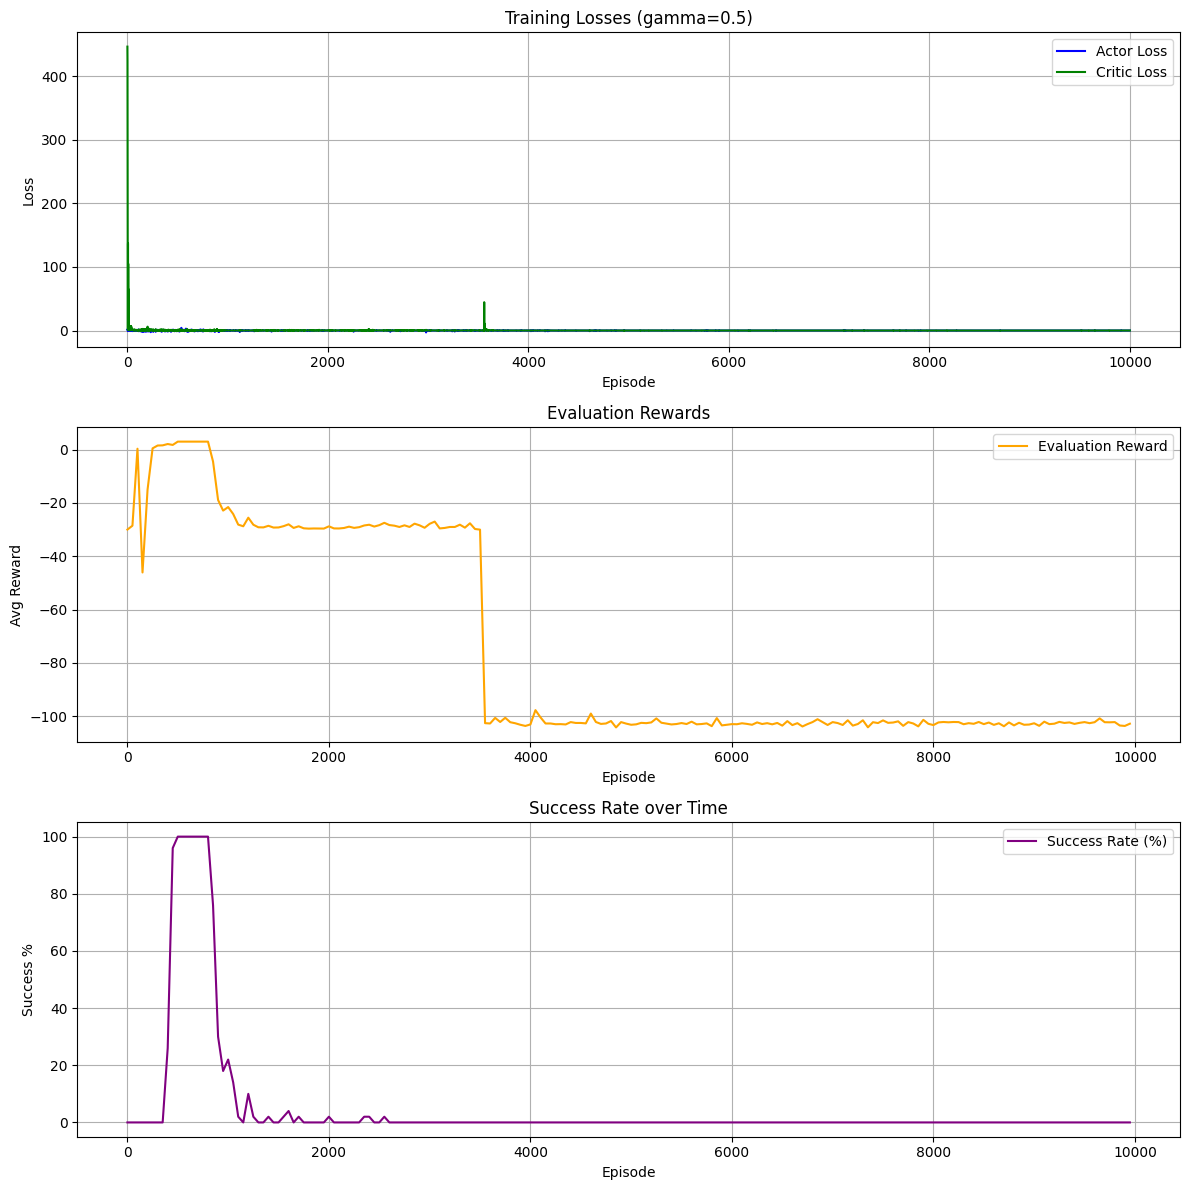

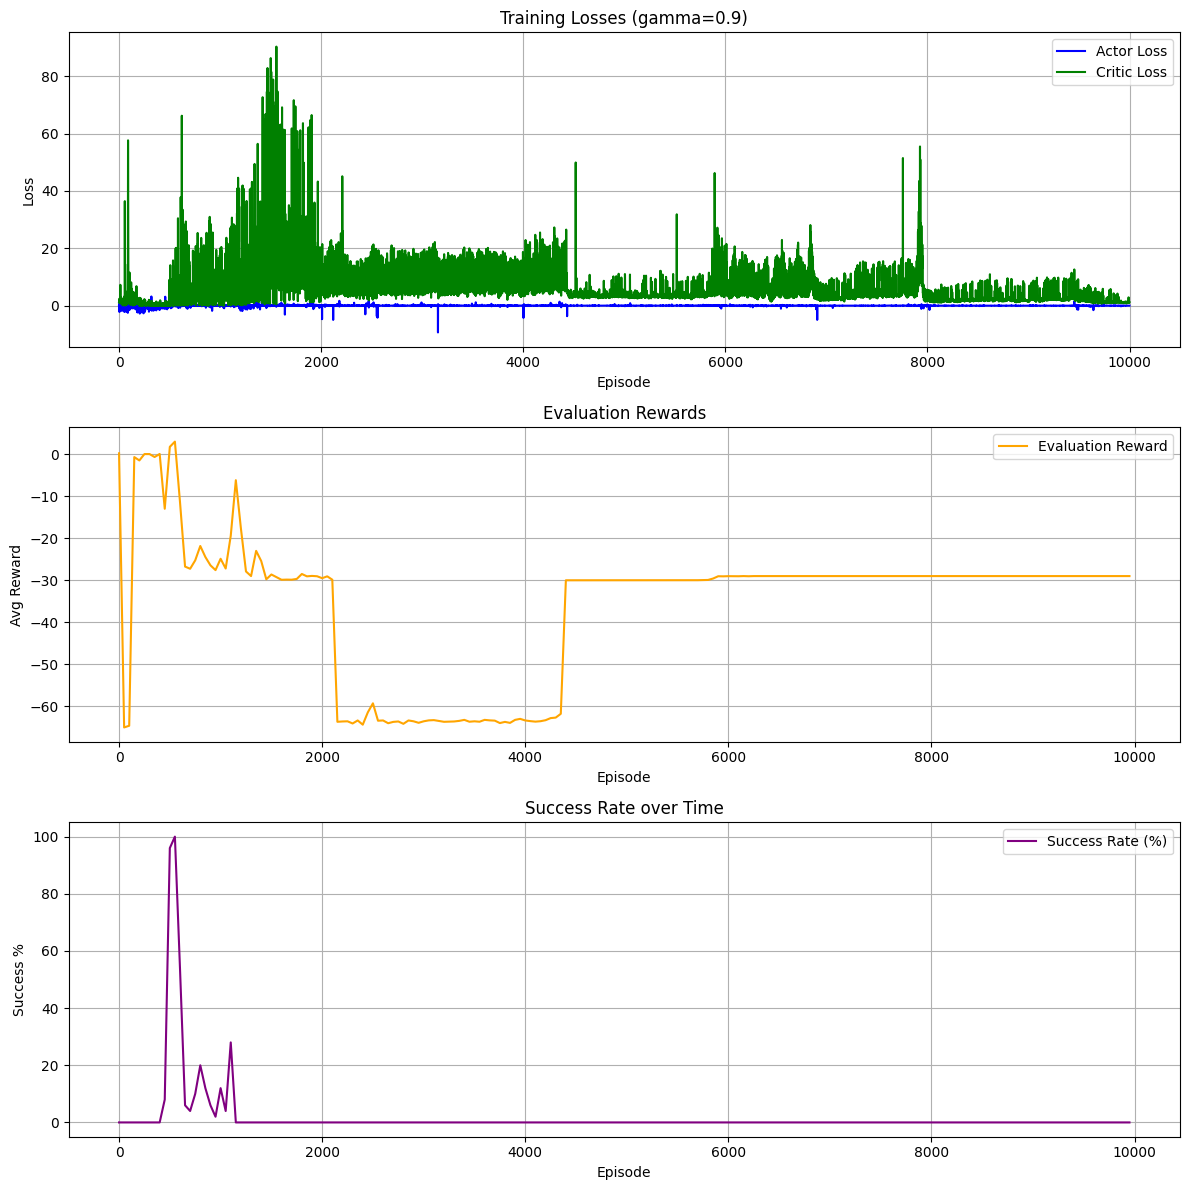

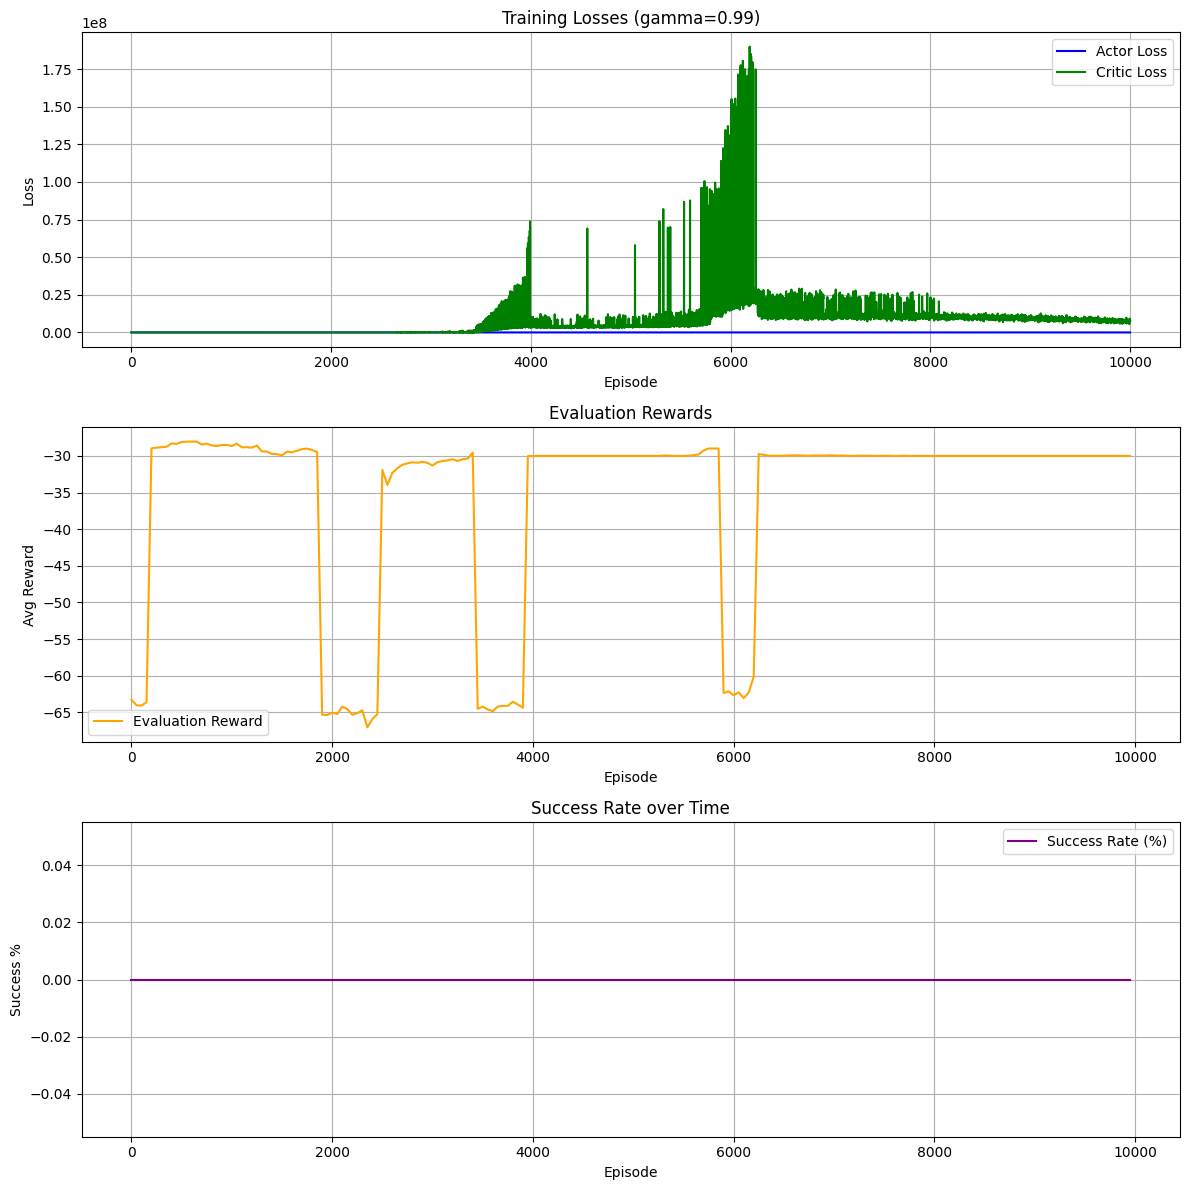

In [17]:
import torch
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.training.train_actor_critic import train_actor_critic
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.plot_results.plot_results_actor_critic import plot_learning_curves

gammas = [0.1, 0.5, 0.9, 0.99]

save_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach", "approach1_simple_event_mapping", "logs")


for gamma in gammas:
    print(f"Training with gamma: {gamma}")
    actor_losses, critic_losses, eval_R, succ_R = train_actor_critic(
        env_name      = "OpenTheChests-v0",
        episodes      = 10000,
        gamma         = gamma,
        lr_actor      = 1e-3,
        lr_critic     = 1e-3,
        eval_interval = 50,
        eval_episodes = 50,
        device        = "cuda" if torch.cuda.is_available() else "cpu"
    )

    plot_learning_curves(
        actor_losses   = actor_losses,
        critic_losses  = critic_losses,
        eval_rewards   = eval_R,
        success_rates  = succ_R,
        eval_interval  = 50,
        gamma          = gamma,
        save_path      = save_path,
    )


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

Why the Actor-Critic with Q-value Critic struggles on `OpenTheChests-v0`


**Observation:**  
With large gamma, the critic loss explodes to very high values, and the average evaluation reward and success rate drop to zero.

**Explanation:**  
The Q-value critic is likely overestimating Q(s, a) for many state-action pairs, leading to unstable updates. Since the policy uses the advantage $A_t = y_t - Q(s_t, a_t)$ to update, if $Q(s_t, a_t)$ is too large, the advantage becomes negative, and the actor is pushed away from good actions. This causes destructive policy updates.

---

**Observation:**  
The agent performs significantly better when using a smaller discount factor, especially `gamma=0.1`.

**Explanation:**  
A smaller γ reduces the impact of future rewards in the Q-value targets:
$$ y_t = r_t + \gamma \cdot \max_a Q(s_{t+1}, a) $$
With γ close to zero, the critic essentially tries to match the immediate reward, which simplifies the task and reduces propagation of noisy or sparse future reward estimates. This leads to more stable updates and better learning in sparse-reward environments like `OpenTheChests-v0`.



</div>

### 1.3. Double DQN



##### Double DQN Pipeline for OpenTheChests-v0

Below is a comprehensive overview of the Double DQN pipeline for the OpenTheChests-v0 environment, where each observation event (A, B, or C) is encoded as a 33-dimensional one-hot vector, and each possible action corresponds to a 3-bit binary vector indicating which chests (out of three) to open.

1. Environment: OpenTheChests-v0
The environment sends a dictionary-based observation that includes an event type (e.g., e_type 0, 1, or 2 for A, B, C) along with color or timing info.

We transform this raw observation into a human-readable dictionary, then use only the symbol field (A, B, or C) for training.

{
  "symbol": "B",  # the event type
  "bg_color": "red",
  "symbol_color": "green",
  "start_time": 0,
  "end_time": 1
}

---

2. State Encoding (simple_encoder)

We map the symbol to a 33D one-hot vector:
Index 1 for 'A', index 2 for 'B', index 3 for 'C', and 0 for unknown/noise.
For instance, {"symbol": "B"} → [0, 0, 1, 0].

This yields a 4-dimensional state vector for the neural network input.

---

3. Action Space

The environment has up to 3 chests. Each action is represented as a 3-bit binary vector [a2, a1, a0], where each bit indicates whether to open a given chest or not (1 = open, 0 = skip).

Therefore, there are 8 possible actions.

We index these 8 actions from 0 to 7.

E.g. index 4 → binary 100 → [1, 0, 0] (open the first chest only).

---

4. Action Selection with a Q-Network

The encoded 4D state goes into the QNetwork, which outputs 8 Q-values (one per action).
We pick an action index via ϵ-greedy:
  - With probability ϵ, choose a random action (0–7).
  - Otherwise, choose argmax_a Q(s,a).

We convert the chosen action index back to a 3-bit vector (convert_index_to_action) 
to execute in the environment.

---

5. Replay Buffer

Each transition (state, action, reward, next_state, done) is stored in a replay buffer.
We encode the action as a one-hot 8D vector for training convenience 
(using action_encoder), so we can compute Q(s,a) by taking a dot product of the Q-values 
with the one-hot action.

---

6. Double DQN (QNetwork + Target Network)

We maintain two networks:
  - q_net (the main network, updated each training step)
  - target_net (the target network, updated less frequently for stable training)

Training step:
  1. Sample a mini-batch from the replay buffer.
  2. Compute Q(s,a) using q_net.
  3. For Double DQN:
     - Select the action a' = argmax_{a'} Q_main(s', a').
     - Evaluate Q_target(s', a').
  4. The target for each transition is r + γ Q_target(s', a') if not done; otherwise r.
  5. We compute the MSE loss w.r.t. Q(s,a), backpropagate, and update the parameters of q_net.
  6. Periodically copy q_net parameters to target_net.

---

7. Full Training Loop

Initialization:
  - Create the environment, instantiate both q_net and target_net with the same weights,
    and set up the replay buffer.

Loop over episodes (e.g., 20,000):
  1. Convert the current observation to a 4D state.
  2. Select an action via ϵ-greedy.
  3. Execute it in OpenTheChests-v0, obtaining (reward, next_state, done).
  4. Store the transition in the replay buffer.
  5. Perform a training step (sample from the buffer and update q_net) if the buffer 
     is sufficiently filled.
  6. Periodically synchronize target_net with q_net.

Evaluation:
  - At intervals (e.g., every 50 episodes), run a test with ϵ = 0 or a minimal exploration 
    strategy over multiple episodes.
  - Measure the average episode reward and success rate (percentage of episodes 
    with positive reward).

This way, the agent learns to identify which chests to open (among 8 possible actions) 
based on the symbolic event (A/B/C) encoded in a 4D state vector, while leveraging 
a stable Double DQN framework to progressively master this environment.

##### Training

Training with gamma: 0.99
[Gamma 0.99] Episode 0 - AvgReward: -62.91, Success: 0.0%
[Gamma 0.99] Episode 50 - AvgReward: -63.11, Success: 0.0%
[Gamma 0.99] Episode 100 - AvgReward: -63.47, Success: 0.0%
[Gamma 0.99] Episode 150 - AvgReward: -63.36, Success: 0.0%
[Gamma 0.99] Episode 200 - AvgReward: -96.75, Success: 0.0%
[Gamma 0.99] Episode 250 - AvgReward: -50.49, Success: 0.0%
[Gamma 0.99] Episode 300 - AvgReward: -4.75, Success: 64.0%
[Gamma 0.99] Episode 350 - AvgReward: 3.00, Success: 100.0%
[Gamma 0.99] Episode 400 - AvgReward: 2.92, Success: 93.0%
[Gamma 0.99] Episode 450 - AvgReward: 2.95, Success: 95.0%
[Gamma 0.99] Episode 500 - AvgReward: 2.99, Success: 99.0%
[Gamma 0.99] Episode 550 - AvgReward: 3.00, Success: 100.0%
[Gamma 0.99] Episode 600 - AvgReward: 2.99, Success: 99.0%
[Gamma 0.99] Episode 650 - AvgReward: -1.87, Success: 86.0%
[Gamma 0.99] Episode 700 - AvgReward: 3.00, Success: 100.0%
[Gamma 0.99] Episode 750 - AvgReward: 0.99, Success: 80.0%
[Gamma 0.99] Episode 8

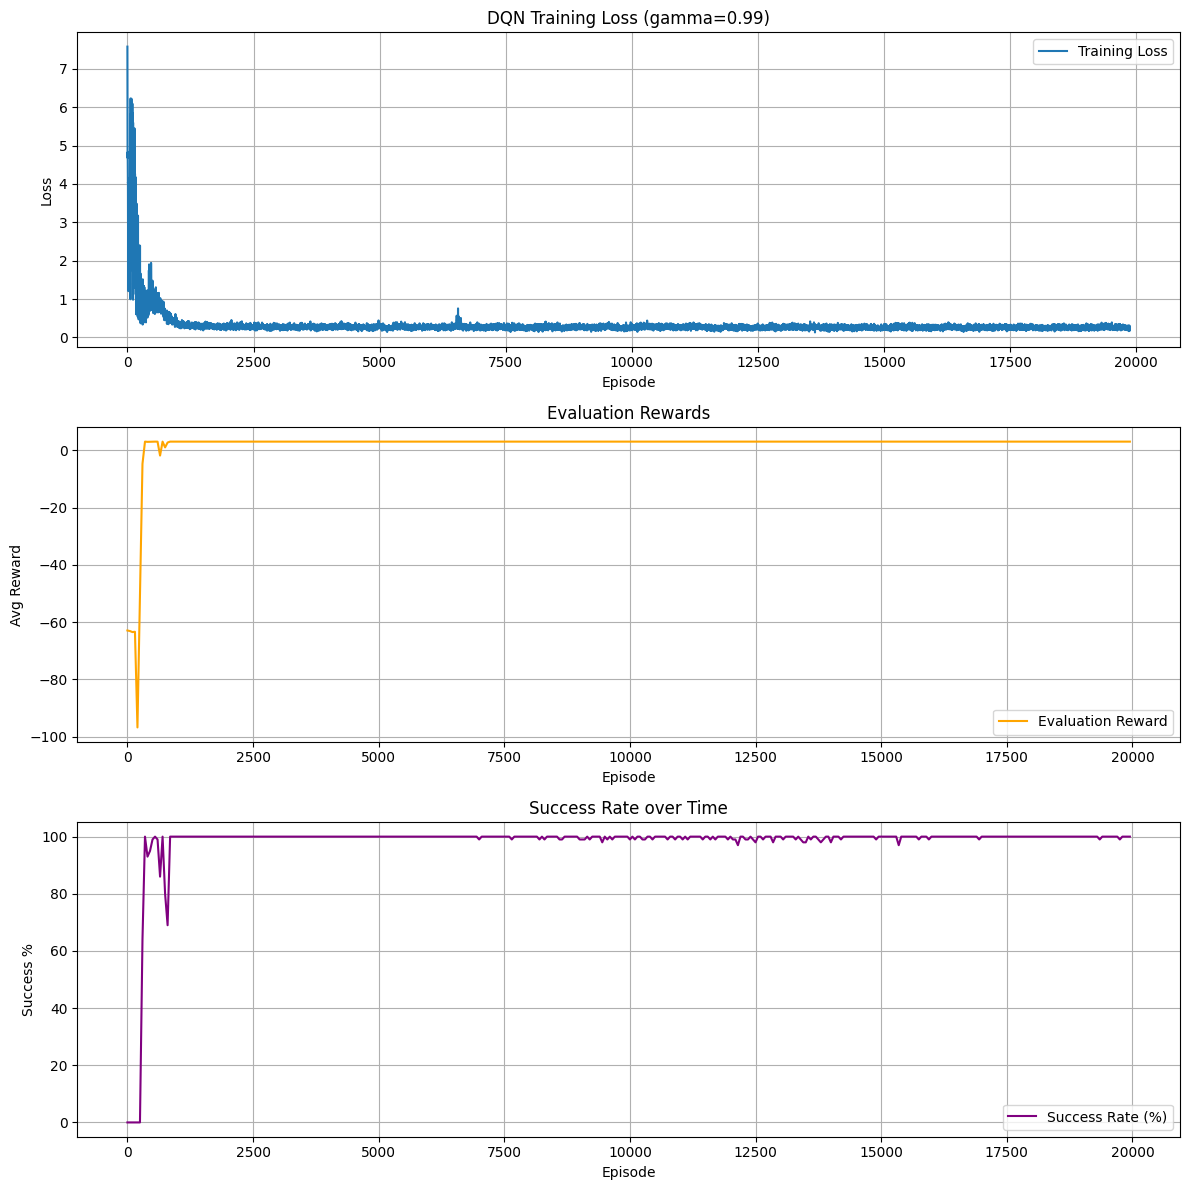

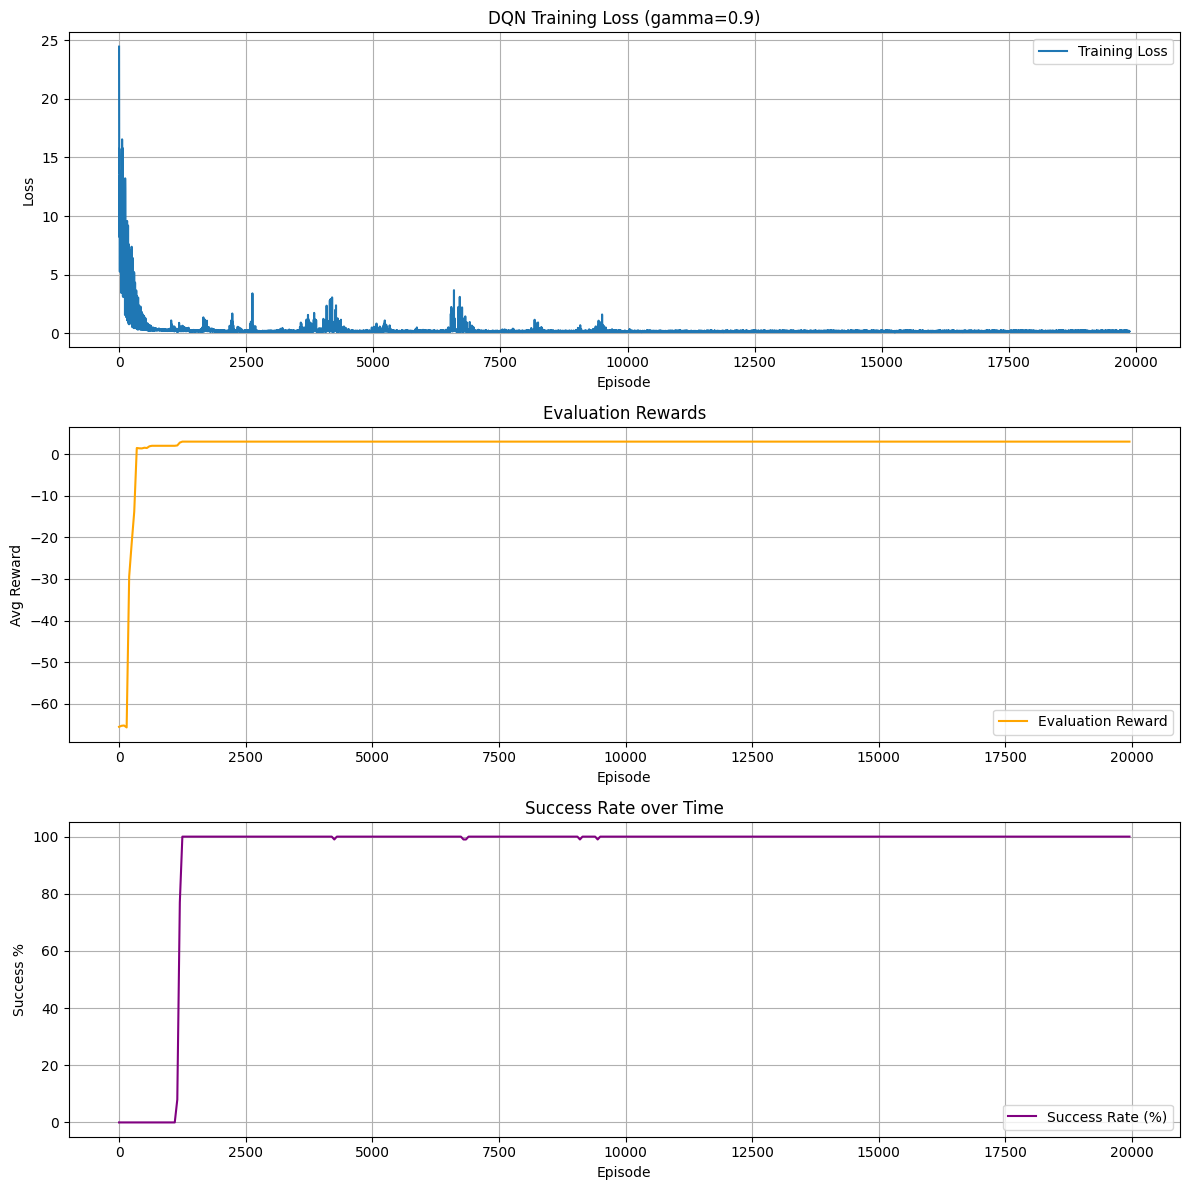

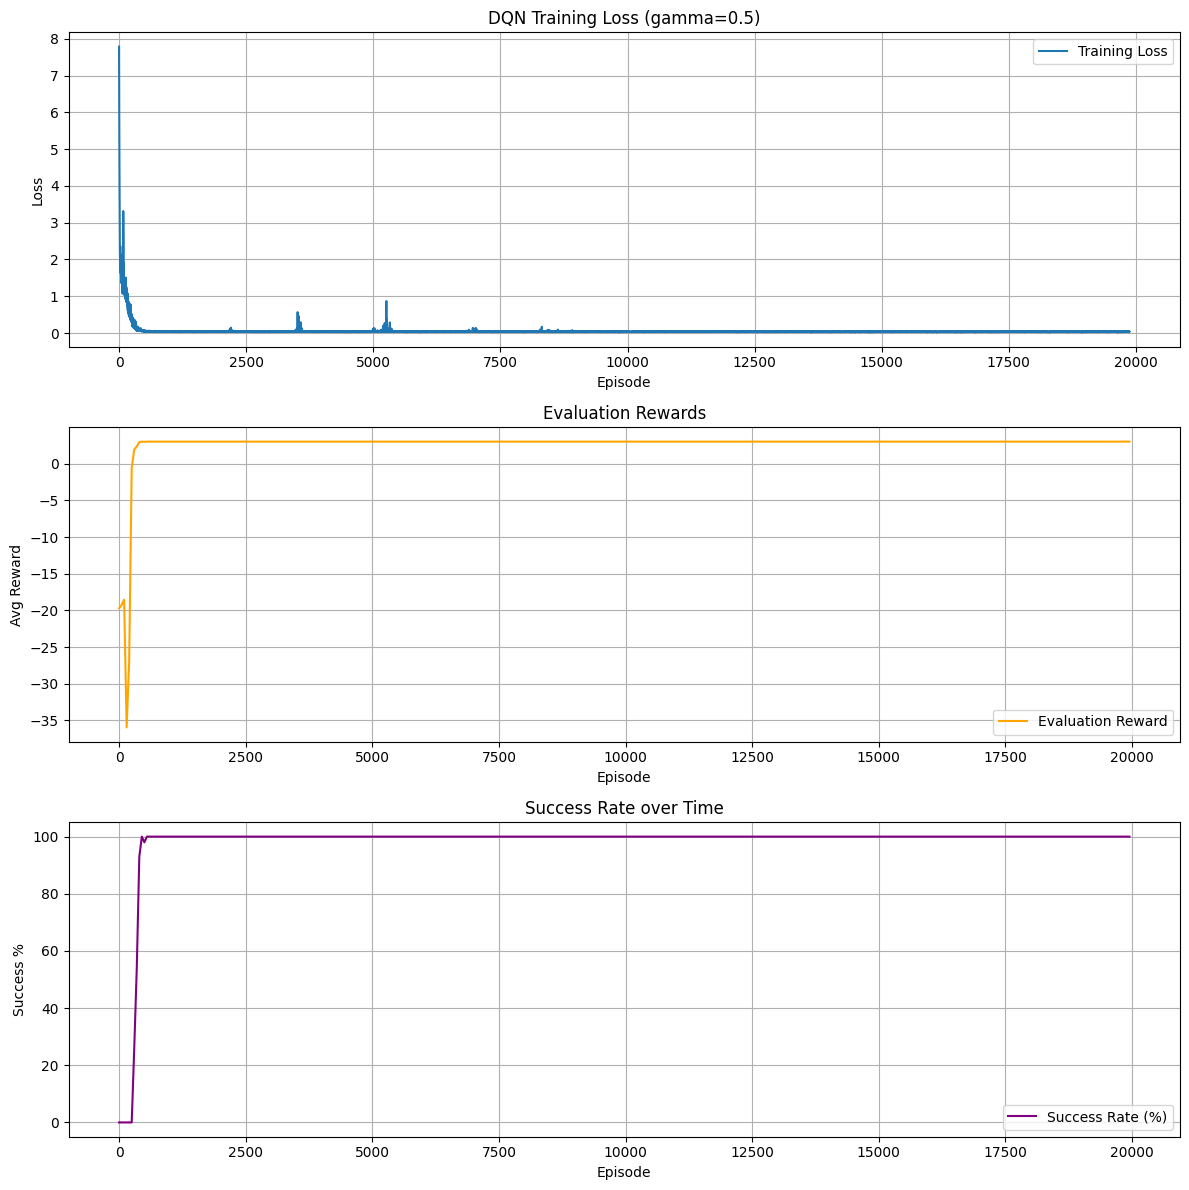

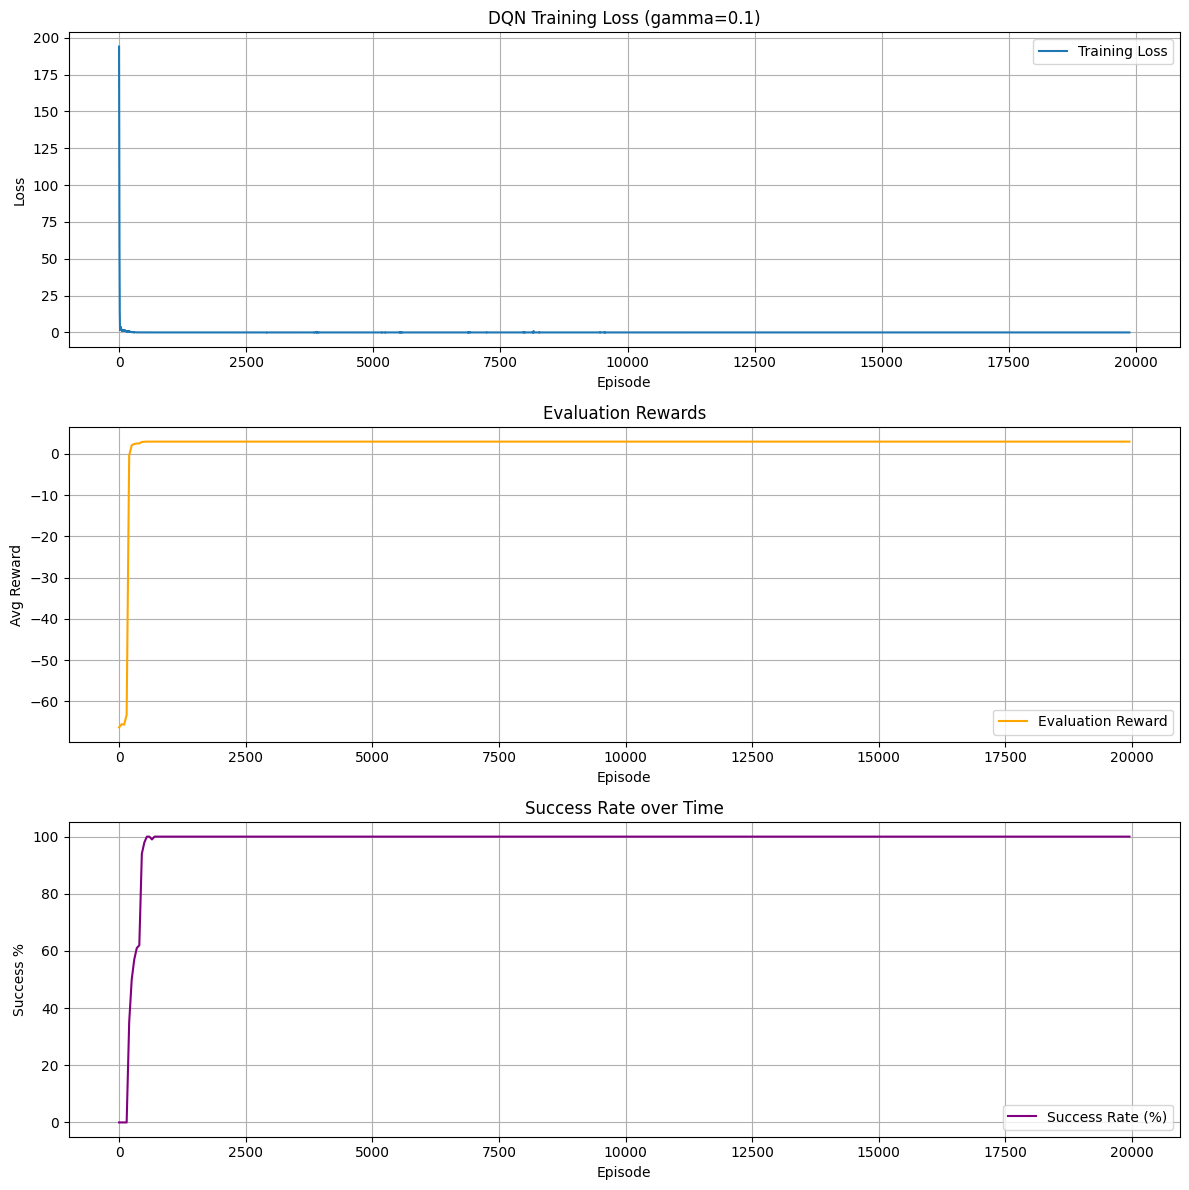

In [ ]:

import torch
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.training.train_agent_dqn import train_agent
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.plot_results.plot_results_dqn import plot_learning_curves_dqn

save_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach", "approach1_simple_event_mapping", "logs")

# Parameters
env_name = "OpenTheChests-v0"
epochs = 20000
evaluation_interval = 50   
evaluation_episodes = 100  
gammas = [0.99, 0.9, 0.5,0.1]
learning_rate = 1e-3
batch_size = 128
buffer_capacity = 10000
eps = 0.1  

device = "cuda" if torch.cuda.is_available() else "cpu"

for gamma in gammas:
    print(f"Training with gamma: {gamma}")
    
    # Training
    training_loss, eval_rewards, success_rates = train_agent(
        env_name=env_name,
        buffer_capacity=buffer_capacity,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        gamma=gamma,
        evaluation_interval=evaluation_interval,
        evaluation_episodes=evaluation_episodes,
        eps=eps,
    )

    plot_learning_curves_dqn(
        training_loss=training_loss,
        eval_rewards=eval_rewards,
        success_rates=success_rates,
        eval_interval=evaluation_interval,
        gamma=gamma,
        save_path=save_path,
    )


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

1. Double DQN Performs very well on OpenTheChests-v0

- **Observation**  
  The Double DQN agent quickly achieves an average evaluation reward of 3.0 (i.e. opening all three chests) and reaches a 100% success rate within just a few hundred episodes.  

- **Explanation**  
  OpenTheChests-v0 is a relatively small, deterministic environment with only three chests to open in sequence. Double DQN’s decoupled action selection and evaluation networks reduce overestimation bias in the Q-value updates, leading to very stable and accurate value estimates. This translates into near-optimal policies almost immediately, hence the perfect rewards and success rates.

2. Impact of Discount Factor (γ)

- **Observation**  
  As the discount factor γ decreases (e.g. from 0.99 → 0.1), the training loss curves become smoother, the evaluation rewards converge faster to 3.0, and the success rate reaches 100% even sooner.  

- **Explanation**  
  A smaller γ places more emphasis on immediate rewards, which in this task correspond directly to opening the next chest. By focusing less on distant future rewards, the agent’s Q-updates become less noisy and more myopic, accelerating convergence. In OpenTheChests-v0, where immediate feedback is highly informative, a lower γ thus yields faster and more stable learning.
"""


</div>

<div style="border: 2px solid #2196F3; padding: 10px; border-radius: 5px;">

  <strong style="color: #2196F3;">The best model, the best config for approach 1:</strong><br><br>

  The best model is clearly the <strong>Double DQN</strong><br>

  And the best config is with <strong>gamma=0.1</strong>

</div>


## 2. Intermediate Approach: Temporal Window

### 2.1. Environnement analysis

##### Visualization

In [6]:
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs

register_custom_envs()

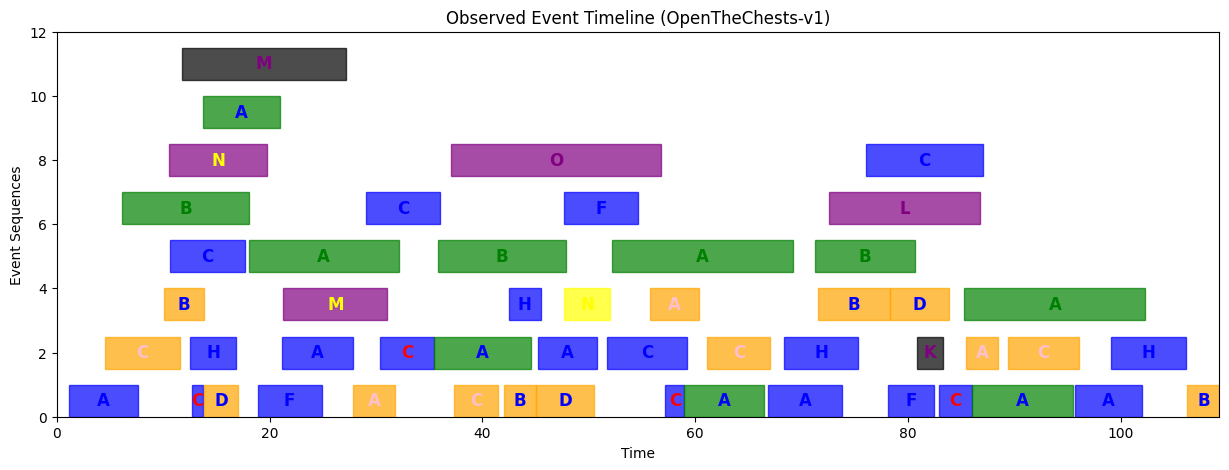

In [20]:
from agent1_patterns_chests_to_reach.utils.visualization import draw_event_sequence_matplot
from agent1_patterns_chests_to_reach.utils.data_collectors import *

observed_events_hard = collect_observations("OpenTheChests-v1", num_steps=50)

draw_event_sequence_matplot(observed_events_hard, start_time=0, end_time=observed_events_hard[-1]["end_time"], env_name="OpenTheChests-v1")



##### One episode analysis

In [ ]:
import gym, matplotlib.pyplot as plt, matplotlib.patches as patches
from agent1_patterns_chests_to_reach.env.register_envs import *
from agent1_patterns_chests_to_reach.utils.visualization import event_from_obs
from agent1_patterns_chests_to_reach.utils.event_encoding import (
    event_to_dict_from_gym as event_from_obs_gym     
)

env = gym.make("OpenTheChests-v1")  


fixed_action = False      
n_steps      = 50

obs = env.reset()
for step in range(1, n_steps + 1):
    if fixed_action:                                         
        action = 0 if env.action_space.shape == () else np.zeros(env.action_space.shape, dtype=int)
    else:                                                    
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)

    event_dict = event_from_obs_gym(obs, all_types, all_attributes)


    print(f"Step {step:>2}: Action={action}, Reward={reward}, Done={done}, Event={event_dict}")

    if done:                              
        obs = env.reset()
        print("Environment reached a terminal state. Resetting...")

env.close()

Step  1: Action=[0 1 0], Reward=-1, Done=False, Event={'symbol': 'C', 'bg_color': 'orange', 'symbol_color': 'pink', 'start_time': np.float64(7.002738314462114), 'end_time': np.float64(10.002738314462114)}
Step  2: Action=[0 0 0], Reward=0, Done=False, Event={'symbol': 'C', 'bg_color': 'blue', 'symbol_color': 'red', 'start_time': np.float64(10.032675590697108), 'end_time': np.float64(13.291128954281188)}
Step  3: Action=[0 0 0], Reward=0, Done=False, Event={'symbol': 'B', 'bg_color': 'orange', 'symbol_color': 'blue', 'start_time': np.float64(8.475198487888962), 'end_time': np.float64(14.392816415341915)}
Step  4: Action=[1 1 0], Reward=-2, Done=False, Event={'symbol': 'H', 'bg_color': 'blue', 'symbol_color': 'blue', 'start_time': np.float64(11.002738314462114), 'end_time': np.float64(14.905567493832491)}
Step  5: Action=[1 0 1], Reward=-2, Done=False, Event={'symbol': 'B', 'bg_color': 'green', 'symbol_color': 'green', 'start_time': np.float64(7.737736698459716), 'end_time': np.float64(1

##### Target sequence per chest

In [ ]:
from agent1_patterns_chests_to_reach.env.register_envs import (
    register_custom_envs,
    all_types,
    all_attributes,
)
from agent1_patterns_chests_to_reach.approach1_simple_event_mapping.encoder.encoders import convert_index_to_action
import gym

def event_to_dict_from_contex2(obs, event_types, attributes):
    """
    Convert raw obs['context'] from OpenTheChestsGym to a readable dictionary.
    """
    event = obs["context"]
    bg = event.attributes["bg"]
    fg = event.attributes["fg"]
    return {
        "symbol": event.type,
        "bg_color": bg,
        "symbol_color": fg,
        "start_time": event.start,
        "end_time": event.end,
    }

def ensure_3bit_vector(action_or_index):
    import numpy as np
    if isinstance(action_or_index, int):
        return convert_index_to_action(action_or_index)
    elif isinstance(action_or_index, (np.ndarray, list)):
        return np.array(action_or_index, dtype=int)
    else:
        raise ValueError("Unsupported action format")

register_custom_envs()
env = gym.make("OpenTheChests-v1")

env.reset()


inner_env = env.unwrapped.env
patterns = inner_env.patterns
generator = inner_env.generator


print("=== 🎯 TARGET SEQUENCES PER CHEST ===")
for i, pattern in enumerate(patterns):
    print(f"\nChest {i+1}:")
    for event in pattern.full_pattern:
        readable_event = event_to_dict_from_contex2({'context': event}, all_types, all_attributes)
        print(f"  {readable_event}")


print("\n=== ✅ CORRECT ACTION ===")
correct_index = None


if hasattr(generator, "correct_box"):
    correct_index = generator.correct_box
    print("Correct box index (generator):", correct_index)


elif hasattr(inner_env, "_action"):
    correct_index = inner_env._action
    print("Correct box index (internal _action):", correct_index)


if correct_index is None:
    print("\n⚙️ Forcing env.step() to trigger correct action assignment...")
    env.step(env.action_space.sample())
    correct_index = getattr(inner_env, "_action", None)
    print("Correct box index (after step):", correct_index)

# 3-bits action
if correct_index is not None:
    print("🔢 3-bit action:", ensure_3bit_vector(correct_index))
else:
    print("❌ Could not determine correct action.")


=== 🎯 TARGET SEQUENCES PER CHEST ===

Chest 1:
  {'symbol': 'A', 'bg_color': 'blue', 'symbol_color': 'blue', 'start_time': 1.1171519228443119, 'end_time': 5.50589108196955}
  {'symbol': 'C', 'bg_color': 'blue', 'symbol_color': 'red', 'start_time': 10.23339789393243, 'end_time': 11.23339789393243}
  {'symbol': 'C', 'bg_color': 'blue', 'symbol_color': 'blue', 'start_time': 6.50589108196955, 'end_time': 16.787851301840373}
  {'symbol': 'A', 'bg_color': 'green', 'symbol_color': 'blue', 'start_time': 11.23339789393243, 'end_time': 22.23339789393243}

Chest 2:
  {'symbol': 'B', 'bg_color': 'orange', 'symbol_color': 'blue', 'start_time': 7.8348838904193885, 'end_time': 14.149660273104518}
  {'symbol': 'D', 'bg_color': 'orange', 'symbol_color': 'blue', 'start_time': 14.149660273104518, 'end_time': 18.499184443090336}
  {'symbol': 'B', 'bg_color': 'green', 'symbol_color': 'green', 'start_time': 7.798276257917937, 'end_time': 19.108017020954687}
  {'symbol': 'A', 'bg_color': 'green', 'symbol_col

### 2.2 First method: Sliding Window

In [ ]:
Sliding window: [eₜ₋₃, eₜ₋₂, eₜ₋₁, eₜ] → window_size × (33-dim) input state  
│  
▼  
Linear(132 → 64) + ReLU  ← « embedding » MLP  
│  
▼  
Linear(64 → 8)  ← Q(s, a) for each of the 8 discrete actions  
│  
▼  
Q-values vector (8-dim)  
→ Used to compute TD targets and trained via MSE loss

##### WINDOW SIZE = 4

Training with gamma: 0.99
[Gamma 0.99] Episode 0 - AvgReward: -65.25, Success: 0.0%
[Gamma 0.99] Episode 50 - AvgReward: -58.78, Success: 0.0%
[Gamma 0.99] Episode 100 - AvgReward: -55.96, Success: 0.0%
[Gamma 0.99] Episode 150 - AvgReward: -40.03, Success: 0.0%
[Gamma 0.99] Episode 200 - AvgReward: -35.45, Success: 0.0%
[Gamma 0.99] Episode 250 - AvgReward: -35.84, Success: 0.0%
[Gamma 0.99] Episode 300 - AvgReward: -36.13, Success: 0.0%
[Gamma 0.99] Episode 350 - AvgReward: -30.53, Success: 0.0%
[Gamma 0.99] Episode 400 - AvgReward: -25.17, Success: 0.0%
[Gamma 0.99] Episode 450 - AvgReward: -32.16, Success: 0.0%
[Gamma 0.99] Episode 500 - AvgReward: -49.63, Success: 0.0%
[Gamma 0.99] Episode 550 - AvgReward: -32.66, Success: 1.0%
[Gamma 0.99] Episode 600 - AvgReward: -87.27, Success: 0.0%
[Gamma 0.99] Episode 650 - AvgReward: -65.90, Success: 0.0%
[Gamma 0.99] Episode 700 - AvgReward: -22.03, Success: 0.0%
[Gamma 0.99] Episode 750 - AvgReward: -15.60, Success: 0.0%
[Gamma 0.99] Epis

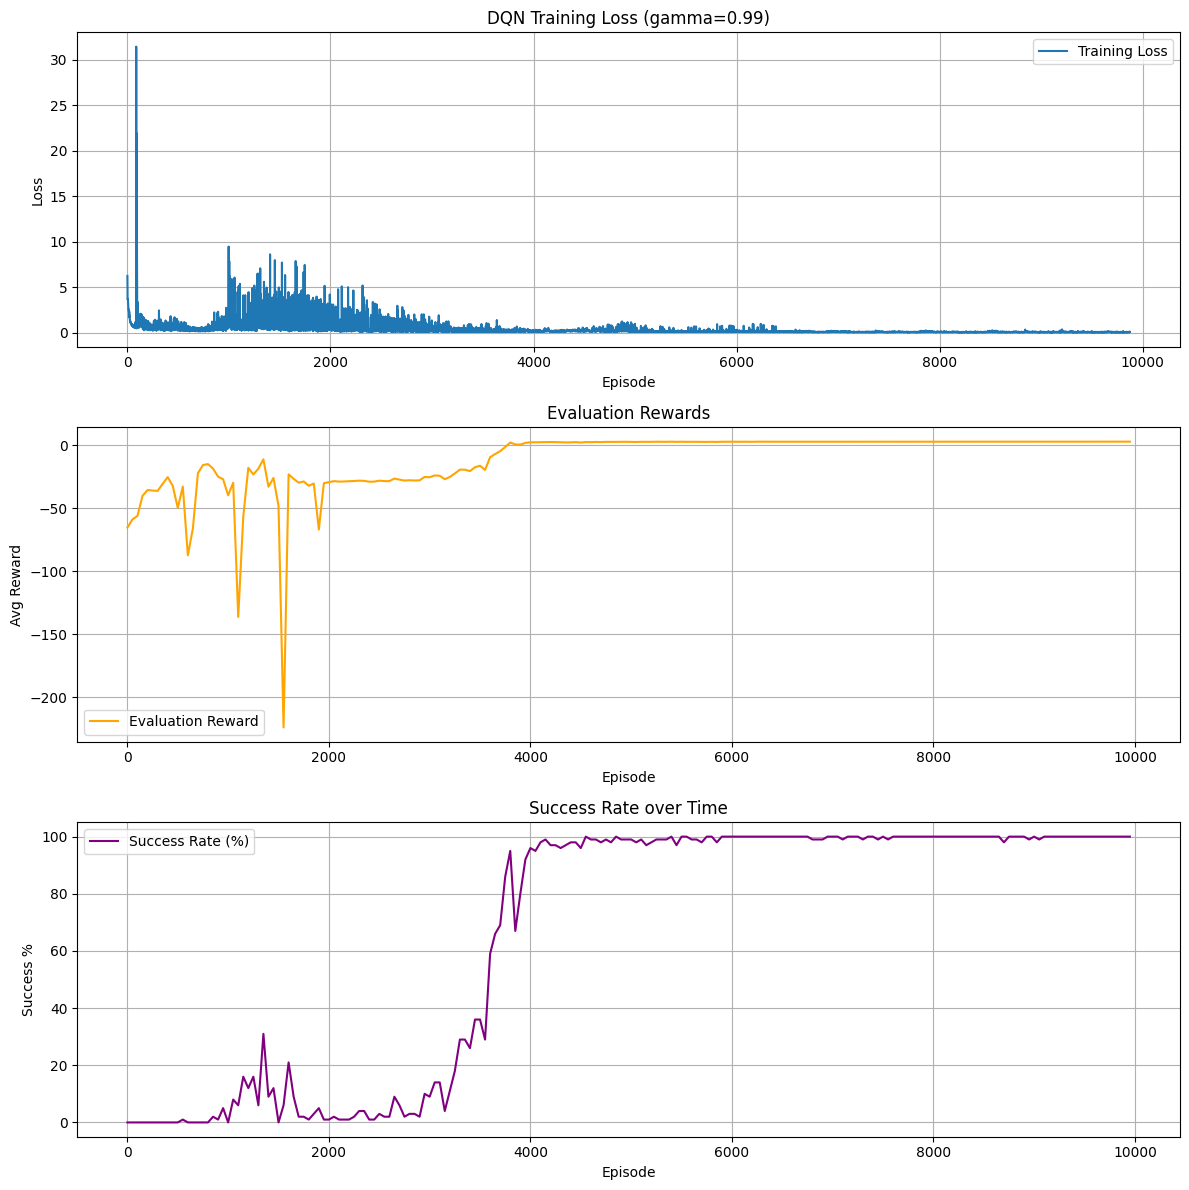

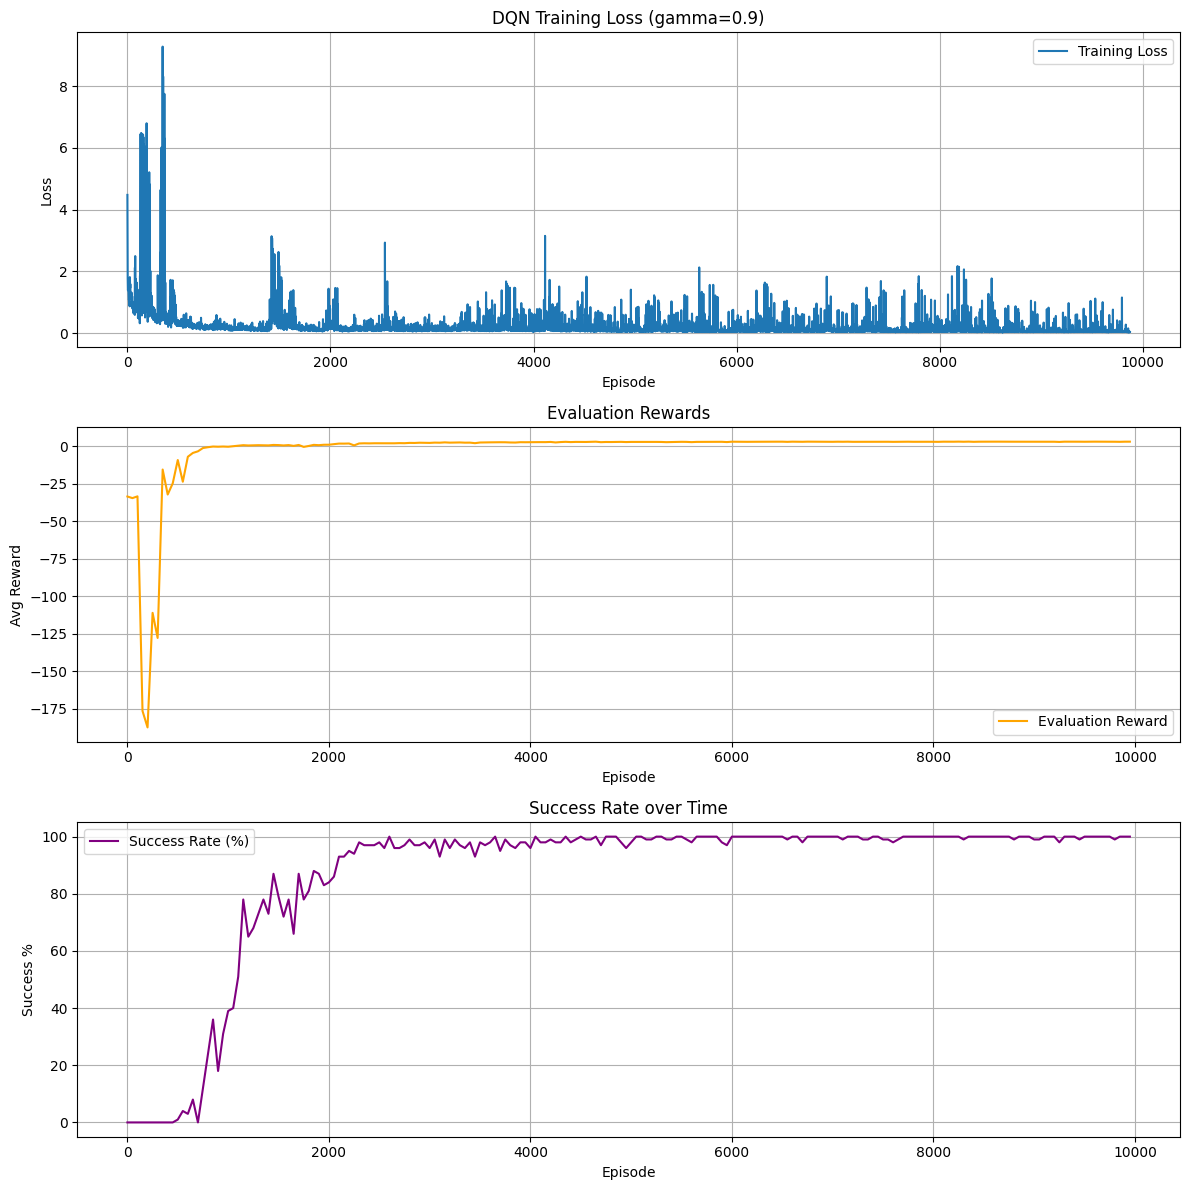

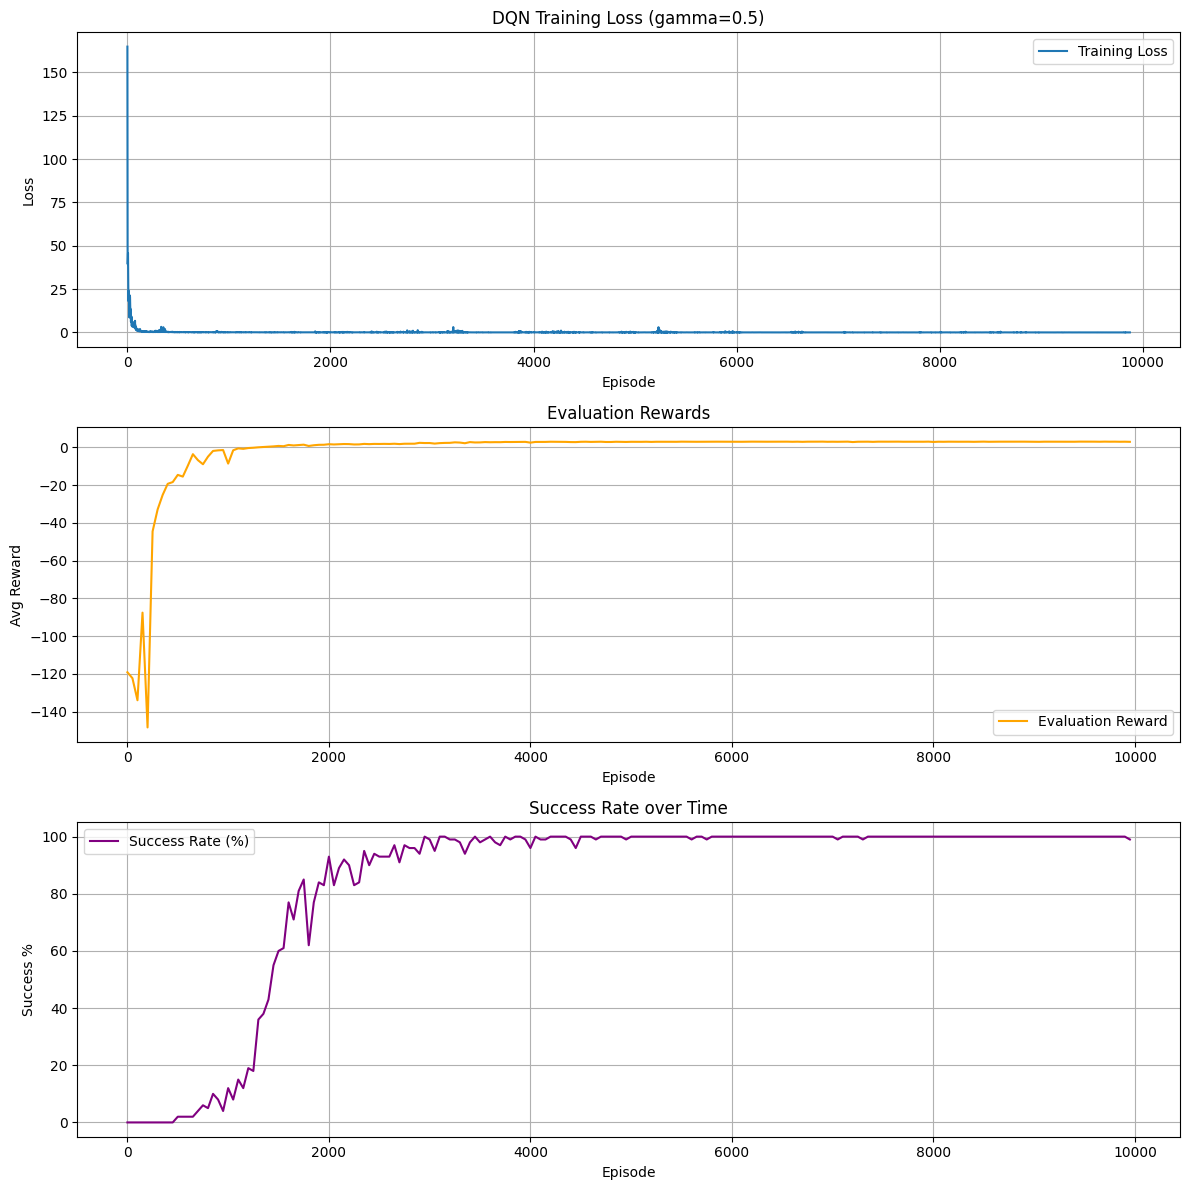

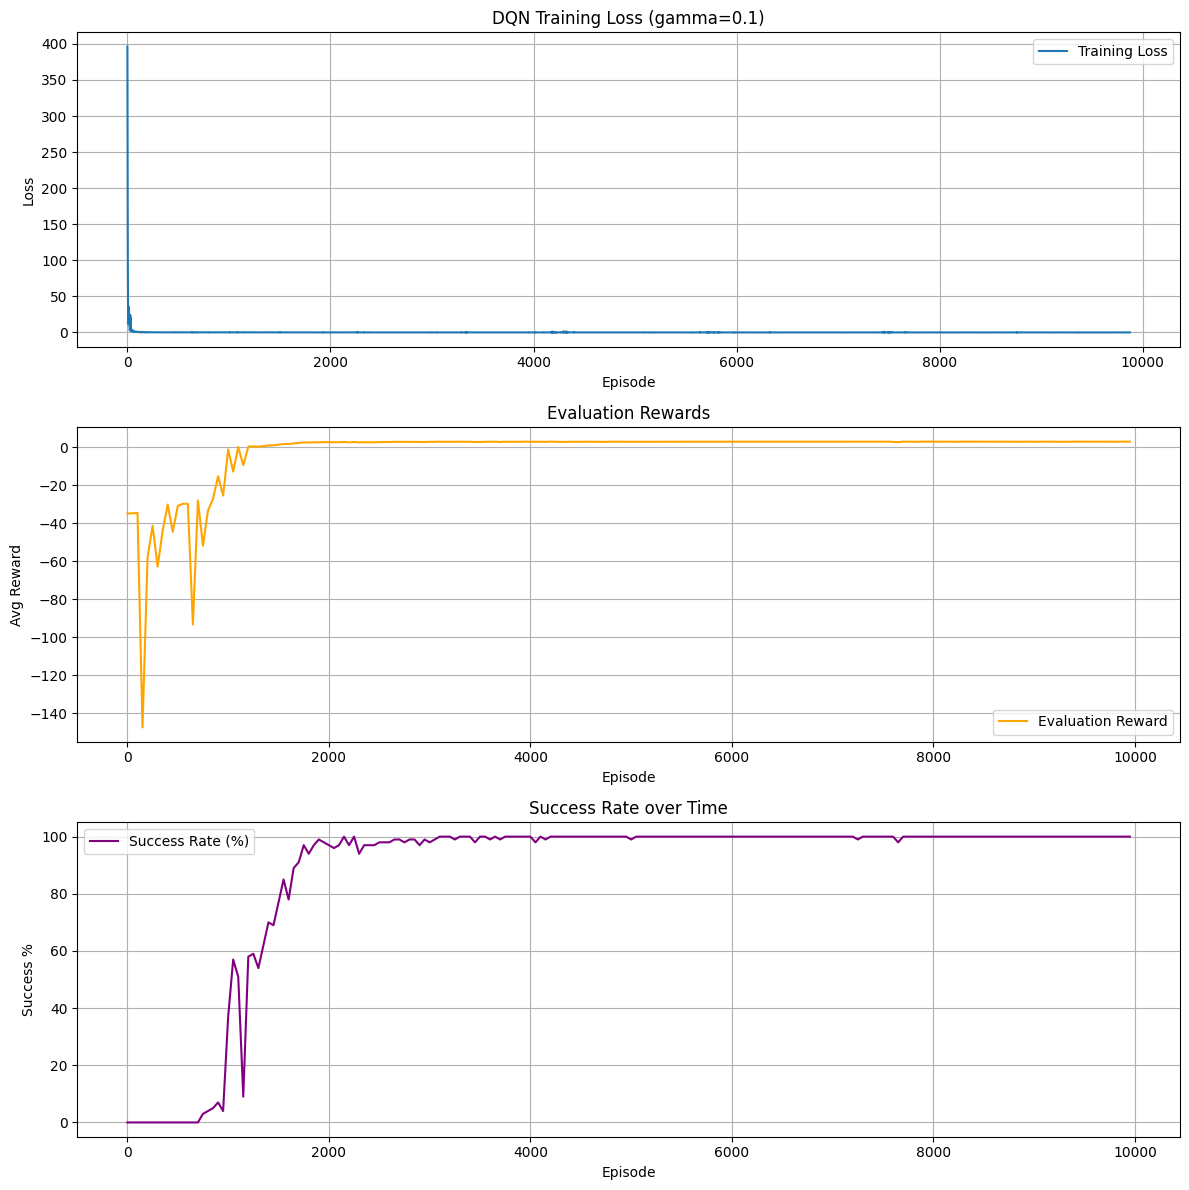

In [ ]:
import torch
from agent1_patterns_chests_to_reach.approach2_temporal_window.training.train_agent_dqn_sliding_window import train_agent
from agent1_patterns_chests_to_reach.approach2_temporal_window.plot_results.plot_results_dqn_sliding_window import plot_learning_curves_dqn


# Parameters
env_name = "OpenTheChests-v1"
epochs = 10000
evaluation_interval = 50   
evaluation_episodes = 100  
gammas = [0.99, 0.9, 0.5,0.1]
learning_rate = 1e-3
batch_size = 128
buffer_capacity = 10000
eps = 0.1  

device = "cuda" if torch.cuda.is_available() else "cpu"

save_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach", "approach2_temporal_window", "logs")

for gamma in gammas:
    print(f"Training with gamma: {gamma}")
    
    # Training
    training_loss, eval_rewards, success_rates = train_agent(
        env_name=env_name,
        buffer_capacity=buffer_capacity,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        gamma=gamma,
        evaluation_interval=evaluation_interval,
        evaluation_episodes=evaluation_episodes,
        eps=eps,
    )

    plot_learning_curves_dqn(
        training_loss=training_loss,
        eval_rewards=eval_rewards,
        success_rates=success_rates,
        eval_interval=evaluation_interval,
        gamma=gamma,
        save_path=save_path,
    )


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment 1: Model performance and method relevance :</font>**  




**Observation**

The Double DQN agent trained with a sliding window encoding performs extremely well:

- All γ configurations eventually reach 100% success rate.

- The training losses stabilize or decay consistently after some episodes.

- The average evaluation rewards approach or reach optimal values rapidly.


**Why are these results good?**

*Sliding Window Captures Temporal Context Efficiently*

The use of a sliding window over the last 4 symbolic events gives the agent a short-term memory of recent transitions. This is crucial in event-based environments like OpenTheChests-v1, where:

- Opening the right chest depends on previous cues (e.g., keys, attributes).
- The agent needs to track symbolic sequences rather than raw spatial states.
- This encoding transforms a partially observable environment into a more Markovian representation — by feeding the agent with enough sequential context (4 × 33D).

*Double DQN Improves Stability and Overestimation Bias*

- The Double DQN algorithm mitigates the common Q-value overestimation problem of standard DQN:
- It decouples action selection and evaluation, leading to more stable learning.
- This fits well with the discrete, symbolic nature of the task, where accurate value estimation is crucial for consistent behavior.

*Why it works well on OpenTheChests-v1*

The environment involves structured sequences of events with discrete symbolic actions, perfect for:

- Q-learning-based methods with action masking or encoding.
- Memory-lite architectures like MLPs + sliding windows.
- Tasks that reward immediate sequences rather than long-horizon planning.
---

**<font color='green'>Comment 2: The influence of γ (discount factor):</font>**  

**Observation**

As γ decreases (from 0.99 → 0.9 → 0.5 → 0.1):

- The convergence becomes faster.
- The evaluation rewards and success rates improve more rapidly.

With γ=0.1, the agent reaches 100% success very early with low and stable loss.

**Why does lower gamma improve performance here?**

*Environment favors short-term decision making*

In OpenTheChests-v1, the goal is to open 3 correct chests as soon as possible. There is:

- No long-term delayed reward.
- No incentive to explore over a long horizon.
→ So prioritizing immediate rewards is optimal.

*Lower γ → less credit assignment delay*

With γ ≈ 0.1, the agent focuses on immediate returns. This leads to:

- Faster learning since the temporal difference target is more reactive.
- Better exploitation of local signal in a small window of events.

*Higher γ adds unnecessary instability*

When γ ≈ 0.99:

- The agent tries to propagate rewards too far back.
- This introduces variance, especially in partially observable settings.
- It leads to longer training and more noisy loss curves (as seen in the γ=0.99 plot).

</div>

### 2.3 Second method: LSTM + Actor without Critic

In [ ]:
# Actor-Only LSTM Policy Architecture


Input: 33-dim state  
│  
▼  
Linear(33 → 64) + ReLU  
  ← “embedding” MLP  
│  
▼  
LSTM(input_size=64, hidden_size=128)  
  ← maintains hidden state (hₜ, cₜ) across steps  
│  
▼  
Linear(128 → 8)  
  ← policy head producing logits for 8 actions  
│  
▼  
Softmax → 8-dim action probabilities  
│  
▼  
Sample (or argmax) → chosen action  


In [4]:
import torch

/Users/robinguiavarch/Library/Caches/pypoetry/virtualenvs/robot-task-recognition-rl-5EzxE_ra-py3.13/lib/python3.13/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


[Ep   200] EvalR -30.00 | Success 0.0%
[Ep   400] EvalR -30.00 | Success 0.0%
[Ep   600] EvalR -30.00 | Success 0.0%
[Ep   800] EvalR -30.00 | Success 0.0%
[Ep  1000] EvalR -30.00 | Success 0.0%
[Ep  1200] EvalR -30.00 | Success 0.0%
[Ep  1400] EvalR -30.00 | Success 0.0%
[Ep  1600] EvalR -30.00 | Success 0.0%
[Ep  1800] EvalR -30.00 | Success 0.0%
[Ep  2000] EvalR -30.00 | Success 0.0%
[Ep  2200] EvalR -30.00 | Success 0.0%
[Ep  2400] EvalR -30.00 | Success 0.0%
[Ep  2600] EvalR -30.00 | Success 0.0%
[Ep  2800] EvalR -30.00 | Success 0.0%
[Ep  3000] EvalR -30.00 | Success 0.0%
[Ep  3200] EvalR -30.00 | Success 0.0%
[Ep  3400] EvalR -30.00 | Success 0.0%
[Ep  3600] EvalR -30.00 | Success 0.0%
[Ep  3800] EvalR -30.00 | Success 0.0%
[Ep  4000] EvalR -30.00 | Success 0.0%
[Ep  4200] EvalR -30.00 | Success 0.0%
[Ep  4400] EvalR -30.00 | Success 0.0%
[Ep  4600] EvalR -30.00 | Success 0.0%
[Ep  4800] EvalR -30.00 | Success 0.0%
[Ep  5000] EvalR -30.00 | Success 0.0%
[Ep  5200] EvalR -30.00 |

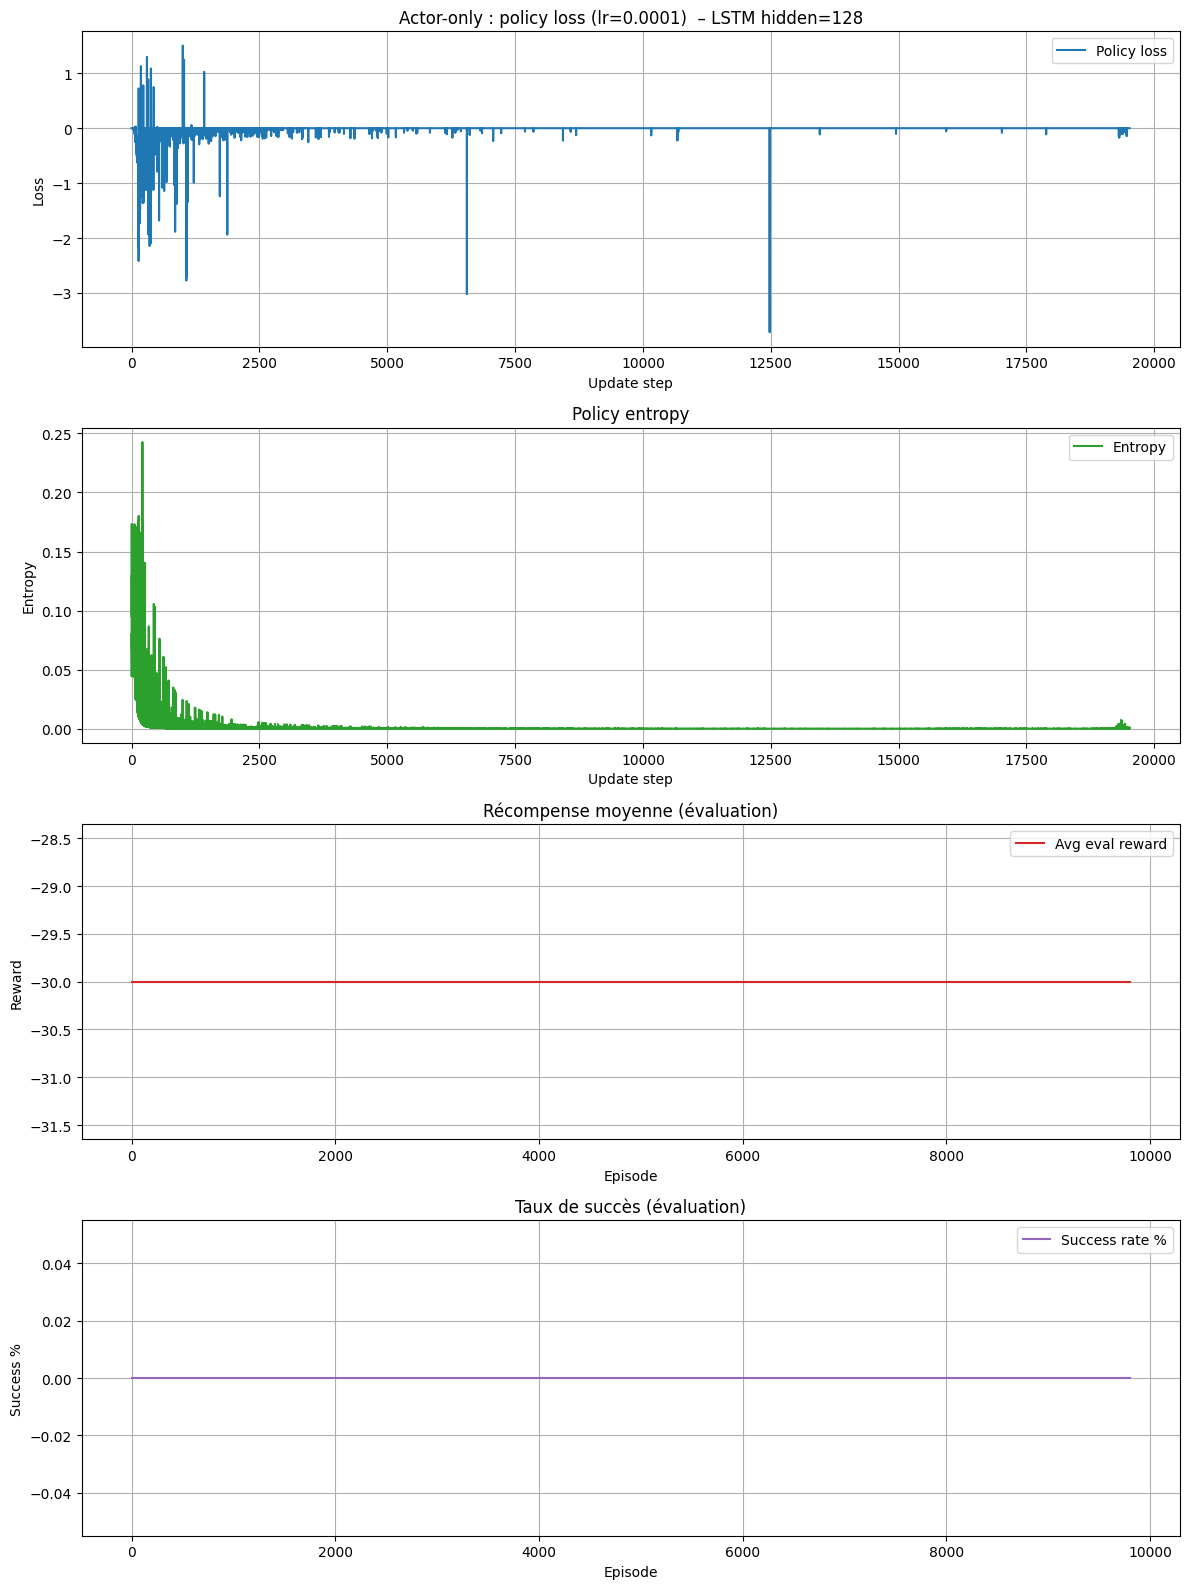

In [ ]:
from agent1_patterns_chests_to_reach.approach2_temporal_window.training.train_agent_actor_lstm \
    import train_agent_actor_lstm
from agent1_patterns_chests_to_reach.approach2_temporal_window.plot_results.plot_results_lstm_actor \
    import plot_learning_curves_actor_lstm

save_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach", "approach2_temporal_window", "logs")


model, pol_loss, ent, eval_R, succ_R = train_agent_actor_lstm(
    env_name      = "OpenTheChests-v1",
    episodes      = 10_000,
    gamma         = 0.3,
    lr            = 1e-4,
    entropy_coef  = 1e-2,
    grad_clip     = 1.0,
    rollout_len   = 128,  
    eval_every    = 200,
    eval_episodes = 50,
    device        = "cuda" if torch.cuda.is_available() else "cpu",
)

# ------------ viz ---------------------------------------------
plot_learning_curves_actor_lstm(
    policy_losses = pol_loss,
    entropies     = ent,
    eval_rewards  = eval_R,
    success_rates = succ_R,
    eval_interval = 200,
    lr            = 1e-4,
    lstm_hidden   = model.lstm.hidden_size,
    save_path     = save_path
)


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment 1: approach :</font>**  


We’ve tried two different data­-collection regimes—pure episode­-by­-episode REINFORCE-style Monte Carlo, then fixed‐length (128‐step) PPO‐style rollouts—but neither yielded any learning signal on OpenTheChests-v1. This suggests that simply changing the update horizon isn’t enough: the underlying high variance of on-policy RL without a value baseline (or critic) makes credit assignment in this sparse‐reward, partially observable environment extremely difficult.


---

**<font color='green'>Comment 2: Exploration to improve:</font>**  


- Use advantage normalization or GAE instead of raw MC returns—this stabilizes learning and helps propagate sparse rewards.

- Reward shaping or dense auxiliary losses. Introduce intermediate bonuses (e.g. +0.1 for entering a new room) or predictive auxiliary tasks to guide exploration.

- Increase model capacity or depth. A single‐layer LSTM with 128 units may not capture the complexity of the map; try stacking more LSTM layers or up-sizing.

- Incorporate memory with attention. A Transformer‐style or attention‐augmented RNN may recall distant key pickups better than a vanilla LSTM.

- Curriculum learning. Start on simpler sub‐tasks (e.g. open one chest) before tackling the full three‐chest objective.

- Entropy scheduling. Anneal entropy coefficient from high to low over training to balance exploration vs. exploitation.

- Hyperparameter sweep. Systematically grid‐search learning rates, γ, gradient clip, batch sizes, and rollout lengths.

- Off‐policy pretraining. Collect random or heuristic demonstrations, do behavior cloning warm-start, then fine-tune with RL.

- Better exploration strategy. Use curiosity bonuses, count-based exploration, or parameter noise instead of ε-greedy/softmax only.

---

**<font color='green'>Comment 3: an ill-suited model</font>**  

A pure on-policy Actor-only LSTM (i.e. REINFORCE with no Critic) is ill-suited for OpenTheChests-v1 because:

Sparse, delayed rewards: Three chests must be opened before any positive feedback—Monte Carlo gradients with this sparsity will have astronomically high variance.

Partial observability & long horizons: The LSTM must remember the key’s location across many steps, but without a critic it can’t effectively propagate credit back through time.

No value function: Without learning state values, the policy can’t distinguish “almost succeeded” from “completely failed” trajectories, so it never converges toward the multi-step latch.

High stochasticity: On-policy sampling without variance reduction (e.g. GAE, baselines) means useful updates almost never accumulate.

</div>

### 2.4 Third method: Recurrent PPO model

In [ ]:
┌───────────────┐
obs_t  ───▶ │  Feature net  │  shared MLP that maps the 33-D encoded event
            └──────┬────────┘  to an embedding h_t  (e.g. 64–256 units)
                   │
                   ▼
            ┌───────────────┐
            │   LSTM cell   │  (or GRU) keeps a hidden-state (h, c) across the
            └──────┬────────┘  whole episode, enabling partial-observability
                   │
       ┌───────────┴───────────┐
       │                       │
       ▼                       ▼
┌──────────────┐        ┌──────────────┐
│  Actor head  │        │  Critic head │
│ Linear → 8   │        │ Linear → 1   │
│ logits π(a)  │        │ V(s)         │
└──────────────┘        └──────────────┘


Using cpu device
Logging to ./ppo_rnn_tb/RecurrentPPO_1
-----------------------------
| time/              |      |
|    fps             | 3446 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 256  |
-----------------------------


/Users/robinguiavarch/Library/Caches/pypoetry/virtualenvs/robot-task-recognition-rl-5EzxE_ra-py3.13/lib/python3.13/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


-------------------------------------------
| time/                   |               |
|    fps                  | 779           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00023010629 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.08         |
|    explained_variance   | 0.0576        |
|    learning_rate        | 0.0001        |
|    loss                 | 30.8          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00214      |
|    value_loss           | 64            |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 691           |
|    iterations           | 3             |
|    time_elapsed         | 1   

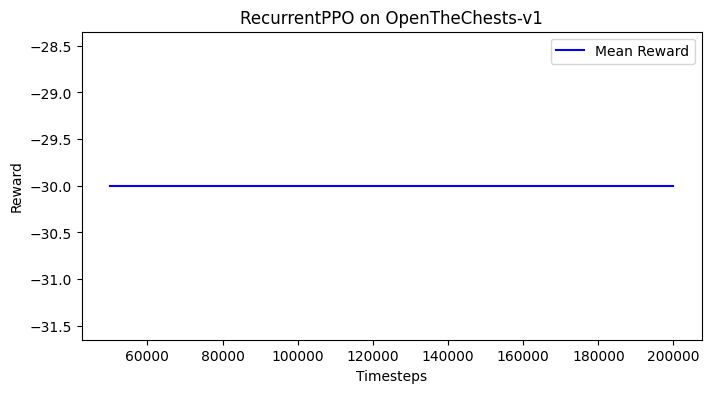

In [11]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs
from agent1_patterns_chests_to_reach.approach2_temporal_window.agents.recurrent_ppo_agent import make_env

register_custom_envs()

# ── logs ─────────────────────────────────────────────────────────
WEIGHTS_DIR = Path("ppo_rnn_weights"); WEIGHTS_DIR.mkdir(exist_ok=True)
LOGS_DIR    = Path("ppo_rnn_logs");    LOGS_DIR.mkdir(exist_ok=True)

# ── envs ───────────────────────────────────────────────────────
train_env = make_env("OpenTheChests-v1")
eval_env  = make_env("OpenTheChests-v1")

# ── model ─────────────────────────────────────────────────
model = RecurrentPPO(
    "MlpLstmPolicy", train_env,
    learning_rate   = 1e-4,     # un peu plus bas
    n_steps         = 256,      # plus long rollouts
    batch_size      = 128,      # plus gros batch
    gamma           = 0.9,     # focus un peu plus sur le futur
    ent_coef        = 0.02,     # encourage l’exploration
    vf_coef         = 0.5,      # classique, à ajuster si vous voulez
    max_grad_norm   = 0.5,
    gae_lambda      = 0.95,
    n_epochs        = 10,       # plus de passes par rollout
    tensorboard_log = "./ppo_rnn_tb",
    verbose         = 1
)

# ── callback eval ────────────────────────────────────────
eval_cb = EvalCallback(
    eval_env,
    best_model_save_path = str(WEIGHTS_DIR),
    log_path             = str(LOGS_DIR),
    eval_freq            = 50_000,
    n_eval_episodes      = 100,
    deterministic        = True
)

# ── training ───────────────────────────────────────────────────────────
model.learn(total_timesteps=200_000, callback=eval_cb)

# ── final evaluation ─────────────────────────────────────────────
mean_r, std_r = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=100,
    deterministic=True
)
print(f"Final mean reward: {mean_r:.2f} ± {std_r:.2f}")

# ── reward curve ────────────────────────────────────────────
data      = np.load(LOGS_DIR / "evaluations.npz")
timesteps = data["timesteps"]
rewards   = data["results"].mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(timesteps, rewards, "b-", label="Mean Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("RecurrentPPO on OpenTheChests-v1")
plt.legend()
plt.show()


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

The 200 k-timestep run did not improve the score — the agent stayed around -30 reward and 0 % success. A longer training should be tried.

</div>

<div style="border: 2px solid #2196F3; padding: 10px; border-radius: 5px;">

  <strong style="color: #2196F3;">The best model, the best config for approach 2:</strong><br><br>

  The best model is clearly the <strong>Double DQN with temporal window</strong><br>

  And the best config is with <strong>gamma=0.1</strong>

</div>


## 3. Advanced Approach: Sequence Modeling (LSTM / Transformer)

### 3.1. Event Visualization

In [ ]:
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs

register_custom_envs()

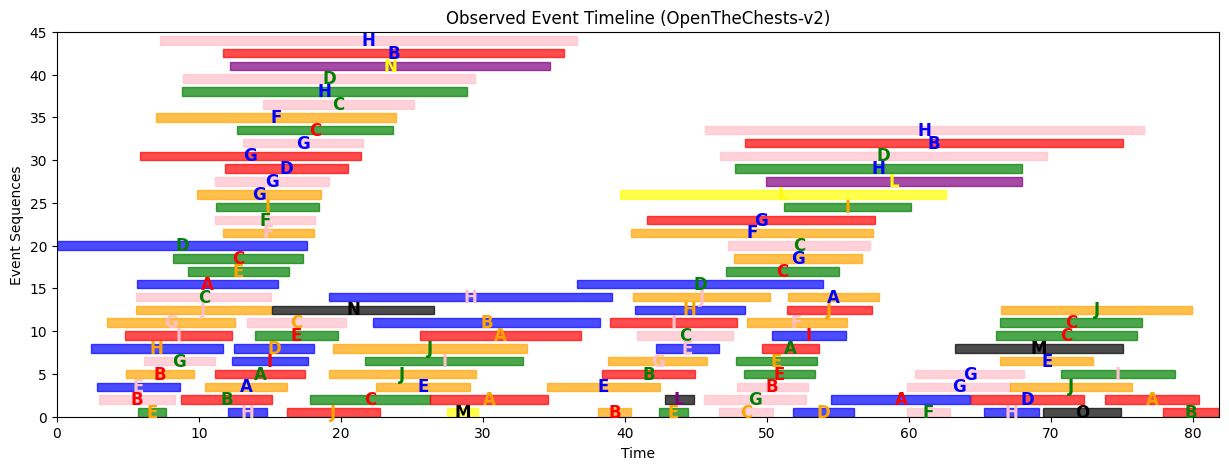

In [ ]:
from agent1_patterns_chests_to_reach.utils.visualization import draw_event_sequence_matplot
from agent1_patterns_chests_to_reach.utils.data_collectors import *

observed_events_hard = collect_observations("OpenTheChests-v2", num_steps=100)

draw_event_sequence_matplot(observed_events_hard, start_time=0, end_time=observed_events_hard[-1]["end_time"], env_name="OpenTheChests-v2")


In [ ]:
import gym, matplotlib.pyplot as plt, matplotlib.patches as patches
from agent1_patterns_chests_to_reach.env.register_envs import *
from agent1_patterns_chests_to_reach.utils.visualization import event_from_obs
from agent1_patterns_chests_to_reach.utils.event_encoding import (
    event_to_dict_from_gym as event_from_obs_gym     
)

env = gym.make("OpenTheChests-v2")  


fixed_action = False      
n_steps      = 100

obs = env.reset()
for step in range(1, n_steps + 1):
    if fixed_action:                                         
        action = 0 if env.action_space.shape == () else np.zeros(env.action_space.shape, dtype=int)
    else:                                                    
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)

    event_dict = event_from_obs_gym(obs, all_types, all_attributes)



    print(f"Step {step:>2}: Action={action}, Reward={reward}, Done={done}, Event={event_dict}")

    if done:                             
        obs = env.reset()
        print("Environment reached a terminal state. Resetting...")

env.close()

Step  1: Action=[0 1 1], Reward=-2, Done=False, Event={'symbol': 'E', 'bg_color': 'blue', 'symbol_color': 'pink', 'start_time': np.float64(3.998406871667585), 'end_time': np.float64(7.998406871667585)}
Step  2: Action=[0 1 0], Reward=-1, Done=False, Event={'symbol': 'G', 'bg_color': 'orange', 'symbol_color': 'pink', 'start_time': np.float64(1.024604382706022), 'end_time': np.float64(8.519195438690435)}
Step  3: Action=[0 1 1], Reward=-2, Done=False, Event={'symbol': 'E', 'bg_color': 'green', 'symbol_color': 'orange', 'start_time': np.float64(6.767940869858892), 'end_time': np.float64(9.68106923094508)}
Step  4: Action=[1 1 1], Reward=-3, Done=False, Event={'symbol': 'H', 'bg_color': 'blue', 'symbol_color': 'orange', 'start_time': np.float64(3.6827239605648616), 'end_time': np.float64(11.190261429043634)}
Step  5: Action=[1 1 0], Reward=-2, Done=False, Event={'symbol': 'I', 'bg_color': 'red', 'symbol_color': 'pink', 'start_time': np.float64(5.454081554604968), 'end_time': np.float64(12.


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

In the OpenTheChests-v2 version, the episode ends as soon as a correct chest is opened, even if the agent opens multiple chests (e.g., two wrong ones and one correct in the same action). The maximum reward per episode is therefore +1.

</div>

### 3.2. On-Policy Transformer Actor

**Overview**

The On-Policy Transformer Actor (OPTA) is an end-to-end policy network that maps the entire history of an episode to the probability distribution of the next action.

- Inputs → 33-dim event feature at every time-step

- Core → Stacked self-attention layers that view the full sequence

- Output → 8-way soft-max defining π(aₜ | obs₀:ₜ)

---

**Observation Embedding**

At each step t the raw feature vector obsₜ ∈ ℝ³³ is linearly projected and activated:

eₜ = ReLU( W_obs · obsₜ + b_obs )  where  W_obs ∈ ℝ^{d × 33}

eₜ ∈ ℝᵈ forms the token that will be fed to the Transformer.

---

**Sequence Construction**

From the beginning of the episode we concatenate the embeddings:

E₀:ₜ = [ e₀ , e₁ , … , e_{t−1} , eₜ ]  shape (t+1, d)

When batching multiple episodes, shorter sequences are right-padded and masked; no truncation is performed.

---

**Temporal / Positional Encoding**

A **fixed** positional vector PE(i) is added so the model knows when each token occurred:

Ē₀:ₜ = E₀:ₜ + PE(0…t)

---

**Transformer Encoder**

Ē₀:ₜ passes through L identical encoder blocks—each containing multi-head self-attention, residual connections, layer normalisation, and a position-wise feed-forward MLP.

The encoder outputs a contextual representation for every token; we keep only the last one:

hₜ = Encoder(Ē₀:ₜ)[-1]      # shape (d,)

---

**Policy Head & Action Distribution**

A final linear layer converts the context vector into logits, followed by softmax:

logitsₜ = W_π · hₜ + b_π     ( W_π ∈ ℝ^{8 × d} )

π(aₜ | obs₀:ₜ) = softmax(logitsₜ)


---

**Training Objective**

- Policy-gradient term

$$
\ell_{\text{PG}} \;=\; -\frac{1}{T}\sum_{t=0}^{T-1} \log \pi\!\bigl(a_t \mid \text{obs}_{0:t}\bigr)\; R_t
$$

- Entropy bonus

$$
H \;=\; -\frac{1}{T}\sum_{t=0}^{T-1}\sum_{a}\, \pi\!\bigl(a_t = a \mid \cdot \bigr)\;
          \log \pi\!\bigl(a_t = a \mid \cdot \bigr)
$$

- Total loss

$$
\mathcal{L} \;=\; \ell_{\text{PG}} \;-\; \beta\, H
$$

In [ ]:
            33-dim obs_t
                │
                ▼
  ϕ_obs : Linear(33 → d) + ReLU         ← observation embedding
                │
   ╔════════════╧════════════╗
   ║  e₀  e₁ … e_{t-1}  e_t ║          ← sequence since episode start
   ╚════════════╤════════════╝
                │   (+ padding if batching)
     + Positional / Time Encoding
                │
     Transformer Encoder (L layers, n_heads, d = d_model)
                │
      take the **last token** output h_t  ∈ ℝᵈ
                │
     Policy head : Linear(d → 8)  → logits_t
                │
     Softmax(logits_t) = π(a_t | obs₀:t)

In [ ]:
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs

register_custom_envs()

In [ ]:
import torch

from agent1_patterns_chests_to_reach.approach3_advanced_sequence_modeling.training.train_opta import train_opta

from agent1_patterns_chests_to_reach.approach3_advanced_sequence_modeling.plot_results.plot_results_opta \
    import plot_learning_curves_opta


save_path = os.path.join(PROJECT_ROOT, "agent1_patterns_chests_to_reach", "approach3_advanced_sequence_modeling", "logs")


# ------------ training ----------------------------------------------
model, pol_loss, ent, eval_R, succ_R = train_opta(
    env_name      = "OpenTheChests-v2",   
    episodes      = 2_000,
    gamma         = 0.9,
    lr            = 5e-3,
    entropy_coef  = 3e-2,
    grad_clip     = 1.0,      
    eval_every    = 200,
    eval_episodes = 50,
    device        = "cuda" if torch.cuda.is_available() else "cpu",
)

plot_learning_curves_opta(
    policy_losses = pol_loss,
    entropies     = ent,
    eval_rewards  = eval_R,
    success_rates = succ_R,
    eval_interval = 200,      
    lr            = 5e-4,    
    d_model       = 128,      
    n_layers      = 4,        
    n_heads       = 4,       
    save_path     = save_path      
)


/Users/robinguiavarch/Library/Caches/pypoetry/virtualenvs/robot-task-recognition-rl-5EzxE_ra-py3.13/lib/python3.13/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


[Ep 200] loss -0.000 | trainR -30.00 | evalR -30.00 | success 0.0%
[Ep 400] loss -0.000 | trainR -30.00 | evalR -30.00 | success 0.0%
[Ep 600] loss -0.000 | trainR -30.00 | evalR -30.00 | success 0.0%
[Ep 800] loss -0.000 | trainR -30.00 | evalR -30.00 | success 0.0%


KeyboardInterrupt: 

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

The current run with the On-Policy Transformer Actor (OPTA) is clearly unsatisfactory. On an Apple-silicon CPU the loop needs roughly 80 minutes to reach 800 episodes, which makes rapid experimentation almost impossible. Even more concerning, the agent’s performance is flat: the average reward is still -30 and the success rate remains at 0 % after every evaluation checkpoint, while the policy-gradient loss oscillates around zero—​a classic sign that the network is not receiving (or not exploiting) a learning signal.

A first remedy is to sweep the hyper-parameters. In practice one can:

- Raise the learning rate (e.g. 3 × 10⁻⁴ → 1 × 10⁻³) so that policy updates have a chance to escape the flat region.
- Lower the entropy coefficient (β = 0.01 → 0.001) to reduce random exploration once the agent starts improving.
- Increase the discount factor (γ = 0.5 → 0.99) so sparse, delayed rewards back-propagate through longer portions of the sequence.
- Expand model capacity (switch from d_model = 128, 4 heads to 256–512, 8 heads) and add gradient-clipping (≤ 0.5) for stability.

Trim the context: instead of feeding the entire episode, keep only the last 50-100 steps—​this shortens sequences, speeds attention and limits vanishing gradients.

Even with careful tuning, however, pure on-policy transformers remain sample-hungry because every gradient update must be generated from the latest roll-outs. To improve sample-efficiency we will pivot to a Transformer-based Double DQN: the transformer still encodes a sliding window of 33-dim event vectors, but learning is now off-policy with experience replay. Double DQN mitigates optimistic value bias and allows thousands of gradient steps per interaction with the environment—​a far better match for our symbolic chest-opening task.

</div>

### 3.3 Transformer Double DQN

In [ ]:
(sliding-window)                         identical copy
   STATE sₜ                             (parameters frozen)
┌──────────────────────────────────┐      ┌──────────────────────────────────┐
│ obsₜ₋W+1  obsₜ₋W+2  …  obsₜ │───│────►│   TARGET (θ⁻)                     │
└──────────────────────────────────┘      └──────────────────────────────────┘
          │                                        ▲
reshape → (W, 33)                                  │
          │                                        │  sync every N steps
          ▼                                        │
ϕ_obs : Linear(33→d) + ReLU  ────┐                 │
          │                     │                  │
+ sinusoidal position encoding(fix embedding)      │
          │                     │                  │
Transformer Encoder (L layers, n_heads, d_model=d) │
          │                     │                  │
take *last* token hₜ ∈ ℝᵈ      │                  │
          │                     │                  │
Q-head : Linear(d→A)            │                  │
(A = 8 discrete actions)        │                  │
          ▼                     │                  │
        Q(sₜ, ·)                │                  │
          │                     │                  │
ε-greedy action selection        │                  │
          ▼                     │                  │
     env.step(aₜ)               │                  │
          │                     │                  │
┌─────────┴────────────────────────────────────────┴───────────┐
|               EXPERIENCE REPLAY BUFFER                       |
|  (s, a, r, s′, done) tuples – sampled in mini-batches        |
└───────────────────────────────────────────────────────────────┘

In [4]:
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs

register_custom_envs()

In [ ]:

import torch
import numpy as np


from agent1_patterns_chests_to_reach.approach3_advanced_sequence_modeling.training.train_transformer_dqn import train_transformer_dqn
from agent1_patterns_chests_to_reach.approach3_advanced_sequence_modeling.plot_results.plot_results_transformer_dqn import plot_results_transformer_dqn


if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Hyper-parameters
env_id        = "OpenTheChests-v2"
episodes      = 2000           # Total training episodes
max_steps     = 200            # Max steps per episode
buffer_size   = 10_000         # Replay buffer capacity
batch_size    = 64             # Batch size for updates
gamma         = 0.5           # Discount factor
lr            = 5e-4           # Learning rate
sync_freq     = 1000           # Sync target network every N steps
eval_interval = 50             # Evaluate every N episodes
eval_episodes = 100            # Episodes per evaluation
save_weights  = "weights/transformer_dqn.pth"
window_size   = 30             # Sliding window length

# Train
training_loss, eval_rewards, success_rates = train_transformer_dqn(
    env_id=env_id,
    device=str(device),
    episodes=episodes,
    max_steps=max_steps,
    buffer_size=buffer_size,
    batch_size=batch_size,
    gamma=gamma,
    lr=lr,
    sync_freq=sync_freq,
    eval_interval=eval_interval,
    eval_episodes=eval_episodes,
)


# Plot
plot_results_transformer_dqn(
    training_loss=training_loss,
    eval_rewards=eval_rewards,
    success_rates=success_rates,
    eval_interval=eval_interval,
    gamma=gamma,
    window_size=window_size,
)


Using MPS (Apple GPU)


/Users/robinguiavarch/Library/Caches/pypoetry/virtualenvs/robot-task-recognition-rl-5EzxE_ra-py3.13/lib/python3.13/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Episode    1 | Reward -120.0 | ε 0.503
Episode    2 | Reward -45.0 | ε 0.185
Episode    3 | Reward -24.0 | ε 0.100
Episode    4 | Reward -24.0 | ε 0.100
Episode    5 | Reward -21.0 | ε 0.100
Episode    6 | Reward -18.0 | ε 0.100
Episode    7 | Reward -17.0 | ε 0.100
Episode    8 | Reward -23.0 | ε 0.100
Episode    9 | Reward -26.0 | ε 0.100
Episode   10 | Reward -27.0 | ε 0.100
Episode   11 | Reward -23.0 | ε 0.100
Episode   12 | Reward -23.0 | ε 0.100
Episode   13 | Reward -31.0 | ε 0.100
Episode   14 | Reward -31.0 | ε 0.100
Episode   15 | Reward -22.0 | ε 0.100
Episode   16 | Reward -17.0 | ε 0.100
Episode   17 | Reward -20.0 | ε 0.100
Episode   18 | Reward -25.0 | ε 0.100
Episode   19 | Reward -22.0 | ε 0.100
Episode   20 | Reward -22.0 | ε 0.100
Episode   21 | Reward -23.0 | ε 0.100
Episode   22 | Reward -17.0 | ε 0.100
Episode   23 | Reward -30.0 | ε 0.100
Episode   24 | Reward -24.0 | ε 0.100
Episode   25 | Reward -25.0 | ε 0.100
Episode   26 | Reward -24.0 | ε 0.100
Episode   2

KeyboardInterrupt: 

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

The training logs above confirm that the Transformer + Double-DQN agent is plateauing: after six hundred episodes the average return still hovers around -25 and the evaluation reward remains close to the worst-case floor (≈ -400).
One strong candidate for this failure is how we handle time in the input sequence.

**Suspected issue – absolute sinusoidal positions**

In the current implementation every 33-dim vector is treated as one token, and we add a fixed sinusoidal encoding that represents its absolute index inside the 30-step sliding window.
Because the window slides at every step, the same observation is seen under many different “absolute” positions during training:

- time-step 0 of one episode might occupy slot 29 of the next batch,
- an event that was once at “position 3” later appears at “position 17”, etc.

For a fully self-attention model this positional aliasing is harmful:

- the network cannot form stable associations between content and position,
- Q-value estimates become noisy because the positional phase shifts carry no consistent meaning,
- gradients on the sinusoidal basis never adapt (they are constant), so the model has no way to correct the mismatch.

In short, the positional encoding is working against the sliding window, scrambling the temporal signal the agent needs to learn credit assignment.

**Next step – let the model learn its own temporal embedding**

</div>

### 3.4 Transformer Double DQN - learnable temporal embedding

In [ ]:
┌─────────────────────────────┐
│   Sliding-Window Sequence   │
│  (L = seq_len = 20 tokens)  │
└──────────────┬──────────────┘
               │  each token = 33-dim encoded event
               ▼
┌──────────────────────────────────────────────┐
│ ϕ_obs : Linear(33 → d_model=256) + ReLU      │
└─────────────────────────┬────────────────────┘
                 │
learned positional embedding  │  PE(i) = Embedding(i)
                 ▼
┌──────────────────────────────────────────────┐
│   Add position  →  X ∈ ℝ^{B×L×256}          │
└─────────────────────────┬────────────────────┘
                 │
┌──────────────────────────────────────────────┐
│ Transformer Encoder (N=1 layer, 4 heads)    │
│  • Multi-Head Self-Attention                │
│  • FFN (4×d_model) + ReLU                   │
│  • Add & Norm residuals                     │
└─────────────────────────┬────────────────────┘
                 │ output shape: (B, L, 256)
temporal pooling  │  ← mean over time‐dimension
                 ▼
┌──────────────────────────────────────────────┐
│   h = mean(X, dim=1)  →  h ∈ ℝ^{B×256}       │
└─────────────────────────┬────────────────────┘
                 │
┌──────────────────────────────────────────────┐
│ BatchNorm1d(256)                            │
└─────────────────────────┬────────────────────┘
                 │
┌──────────────────────────────────────────────┐
│   Q-head (MLP)                               │
│   Linear(256 → 256) + ReLU                   │
│   Linear(256 → 8)                            │
└─────────────────────────┬────────────────────┘
                 │
  Q(s, ·)  → 8 Q-values  (one per 3-bit action)

In [13]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gym
from tqdm import tqdm
from openthechests.src.OpenTheChestsGym import OpenTheChestsGym
from agent1_patterns_chests_to_reach.env.register_envs import register_custom_envs
from agent1_patterns_chests_to_reach.env.register_envs import (
    register_custom_envs,
    all_types,
    all_attributes,
)

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using MPS (Apple GPU)


##### Useful functions

In [15]:
import torch.nn as nn

def encode_symbol_bg_fg(event: dict, all_types, all_attributes) -> np.ndarray:
    """
    Encode an event into a one-hot vector + times:
    [symbol_oh (15D), bg_oh (8D), fg_oh (8D), start_time, end_time].

    Returns a 33D vector.
    """
    symbol_vec = np.zeros(len(all_types), dtype=np.float32)
    bg_vec = np.zeros(len(all_attributes["bg"]), dtype=np.float32)
    fg_vec = np.zeros(len(all_attributes["fg"]), dtype=np.float32)

    # 1) Encode symbol
    symbol = event.get("symbol", None)
    if symbol in all_types:
        symbol_idx = all_types.index(symbol)
        symbol_vec[symbol_idx] = 1.0

    # 2) Encode bg color
    bg_color = event.get("bg_color", None)
    if bg_color in all_attributes["bg"]:
        bg_idx = all_attributes["bg"].index(bg_color)
        bg_vec[bg_idx] = 1.0

    # 3) Encode fg color
    fg_color = event.get("symbol_color", None)
    if fg_color in all_attributes["fg"]:
        fg_idx = all_attributes["fg"].index(fg_color)
        fg_vec[fg_idx] = 1.0

    # 4) Encode times
    # si l'event n'a pas de champ time => 0.0 par défaut
    start_time = float(event.get("start_time", 0.0))
    end_time   = float(event.get("end_time", 0.0))

    # Concatène => 15 + 8 + 8 + 2 = 33D
    return np.concatenate([
        symbol_vec,
        bg_vec,
        fg_vec,
        np.array([start_time, end_time], dtype=np.float32)
    ], axis=0)

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.register_buffer("position_ids",
                             torch.arange(max_len).unsqueeze(0), persistent=False)

    def forward(self, x):
        pos_ids = self.position_ids[:, :x.size(1)]
        return self.pos_emb(pos_ids)


def evaluate_agent(test_env, q_net, episodes=10, seq_len=20, verbose=False, device='cpu'):
    q_net.eval()
    
    total_rewards = []
    
    for ep in range(episodes):
        obs = test_env.reset()
        event_dict = event_from_obs_gym(obs, all_types, all_attributes)
        state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
        done = False
        ep_reward = 0
        ep_steps = 0
        seq_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        while not done:
            #
            steps_done = 0
            # seq_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            while len(seq_state) != seq_len:
                action = np.array([0,0,0])
                obs, reward, done, info = test_env.step(action)
                event_dict = event_from_obs_gym(obs, all_types, all_attributes)
                next_state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
                seq_state = torch.vstack([seq_state, torch.tensor(next_state, dtype=torch.float32, device=device)])
                state = next_state
            action = select_action(q_net, seq_state, eps=0, decay=False, device=device)
            obs, reward, done, info = test_env.step(action)
            event_dict = event_from_obs_gym(obs, all_types, all_attributes)
            next_state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
            seq_state = torch.vstack([seq_state[1:], torch.tensor(next_state, dtype=torch.float32, device=device)])
            #
            ep_reward += reward
            ep_steps += 1

        total_rewards.append(ep_reward)
        
    return np.mean(total_rewards)

def event_from_obs_gym(obs, event_types, attributes):
    """
    Convert observation from Gym-based OpenTheChests environments to a readable dictionary.

    Args:
        obs (dict): Observation containing fields 'e_type', 'bg', 'fg', 'start', and 'end'.
        event_types (list): List of all event type symbols.
        attributes (dict): Dictionary containing foreground and background color mappings.

    Returns:
        dict: Parsed event dictionary with symbol, colors, and timing info.
    """
    return {
        "symbol": event_types[obs["e_type"]],
        "bg_color": attributes["bg"][obs["bg"]],
        "symbol_color": attributes["fg"][obs["fg"]],
        "start_time": obs["start"][0],
        "end_time": obs["end"][0],
    }

def select_action(q_net, state, eps=0.1, decay=True, device='cpu', verbose=False):
    global steps_done
    sample = np.random.rand()
    if decay:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        if episode % 500 == 0 and verbose:
            print(f"eps value: {eps_threshold}")
    else:
        eps_threshold = eps
    if sample < eps_threshold:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            q_net.eval()
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = q_net(state_tensor)
            action = convert_index_to_action(q_values.argmax().item())
            q_net.train()
    steps_done += 1
    return action

def convert_index_to_action(index):
    """
    Convertit un index en action.
    Exemple: 4 -> [1, 0, 0]
    """
    return np.array([int(digit) for digit in bin(index).removeprefix("0b").zfill(3)])

def action_encoder(action_or_index):
    """
    Encode un vecteur binaire de taille 3 (interprété comme bits [a2, a1, a0]) 
    ou un indice en vecteur one-hot de taille 8.
    """
    if isinstance(action_or_index, (np.ndarray, list)):
        action_vec = np.array(action_or_index, dtype=int)
        assert action_vec.shape == (3,), "Le vecteur d'action doit avoir 3 éléments"
        # Convention : bit2, bit1, bit0 → poids fort à gauche
        index = int(action_vec[0] * 4 + action_vec[1] * 2 + action_vec[2] * 1)
    elif isinstance(action_or_index, int):
        index = action_or_index
        assert 0 <= index < 8, "Index d'action hors limite"
    else:
        raise TypeError("action_or_index doit être un vecteur binaire ou un entier")

    encoded_action = np.zeros(8)
    encoded_action[index] = 1
    return encoded_action

def train(q_net, target_q_net, buffer, optimizer, batch_size=10, seq_len=20 , gamma=0.99, device='cpu'):
    
    q_net.train()
    target_q_net.eval()
    
    # Tant que le buffer n’a pas assez de transitions, on ne fait pas d'entraînement
    if len(buffer) < batch_size:
        return

    seq_state, action, reward, next_state, done = buffer.sample(batch_size)

    seq_state = torch.tensor(seq_state, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(dim=1).to(device)
    done = torch.tensor(done, dtype=torch.float32).unsqueeze(1).to(device)

    # Q(s,a)
    q_values = q_net(seq_state)
    q_value = (q_values * action).sum(dim=1, keepdim=True)
    
    # max_a' Q'(s',a')
    with torch.no_grad():
        next_seq_state = torch.concat([seq_state, next_state], dim=1)[:,1:,:]
        next_q_values = target_q_net(next_seq_state)
        # next_q_values = target_q_net(seq_state)
        max_next_q = next_q_values.max(dim=1, keepdim=True).values
        target = reward + gamma * max_next_q * (1 - done)

    loss = nn.MSELoss()(q_value, target)

    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=1.0)
    optimizer.step()
    return loss.item()
    

    

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.register_buffer("position_ids",
                             torch.arange(max_len).unsqueeze(0), persistent=False)

    def forward(self, x):
        pos_ids = self.position_ids[:, :x.size(1)]
        return self.pos_emb(pos_ids)

class TransformerQNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int,
                 seq_len: int = 4, d_model: int = 256,
                 nhead: int = 4, num_layers: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(state_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dim_feedforward=4 * d_model,
            activation="relu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_emb = LearnedPositionalEmbedding(seq_len, d_model)

        self.bn = nn.BatchNorm1d(d_model)

        self.q_head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, action_size)
        )

    def reset_hidden(self, *args, **kwargs):
        return

    def forward(self, seq_state):
        x = self.input_proj(seq_state)          # [B, L, d_model]
        x = x + self.pos_emb(x)                 # add positional embedding
        x = self.encoder(x)                     # [B, L, d_model]
        x = x.mean(dim=1)                       # average over time → [B, d_model]
        x = self.bn(x)                          # BatchNorm1d
        return self.q_head(x)                   # [B, action_size]

In [21]:
import os
import random
from collections import deque
from torch.optim import Adam

state_size = 33
action_size = 8
# gammas = [0.7, 0.6, 0.5, 0.4]
# gammas = [0.5] * 4
# gammas = [0.3, 0.1]
gammas = [0.5]
loss_f_gamma = []
rewards_f_gamma = []
epochs = 10000
steps_done = 0
seq_len = 20
BATCH_SIZE = 128
EPS_END = 0.3
EPS_START = 1
EPS_DECAY = 80000*3
alpha = 0.00001

register_custom_envs()
env_name = 'OpenTheChests-v2'
env = gym.make(env_name)

good_answers_buffer = ReplayBuffer(1000)
bad_answers_buffer = ReplayBuffer(10000)

for i, gamma in enumerate(gammas):
    q_net       = TransformerQNetwork(state_size, action_size,
                                  seq_len=seq_len, num_layers=1).to(device)
    target_q_net = TransformerQNetwork(state_size, action_size,
                                   seq_len=seq_len, num_layers=1).to(device)
    target_q_net.load_state_dict(q_net.state_dict())
    optimizer = Adam(q_net.parameters(), lr=alpha)
    buffer = ReplayBuffer(50_000)

    # Reset environment and initialize observation
    obs = env.reset()
    event_dict = event_from_obs_gym(obs, all_types, all_attributes)
    state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
    seq_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    training_loss = []
    average_rewards = []
    done = False
    early_done = False

    for episode in tqdm(range(epochs), desc="Training episodes"):
        if done:
            obs = env.reset()
            event_dict = event_from_obs_gym(obs, all_types, all_attributes)
            state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
            done, early_done = False, False
            seq_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Do nothing till the sequence comes to an end
        while len(seq_state) != seq_len:
            #
            padded_seq = [seq_state] + [torch.zeros(state_size, dtype=torch.float32, device=device)]* ( seq_len - len(seq_state) )
            padded_seq = torch.vstack(padded_seq)
            action = select_action(q_net, padded_seq, eps=0.9, device=device)
            obs, reward, done, info = env.step(action)
            steps_done += 1
            event_dict = event_from_obs_gym(obs, all_types, all_attributes)
            next_state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
            if done:
                early_done = True
            if not early_done:
                buffer.push(padded_seq.to("cpu").numpy(), action_encoder(action), reward, next_state, done)
            if reward > 0 :
                
                good_answers_buffer.push(padded_seq.cpu().numpy(), action_encoder(action),
                         reward, next_state, done)
            seq_state = torch.vstack([seq_state, torch.tensor(next_state, dtype=torch.float32, device=device)])

        # Execute action according to Q-value
        action = select_action(q_net, seq_state, eps=0.9, device=device, verbose=True)
        obs, reward, done, info = env.step(action)
        steps_done += 1
        event_dict = event_from_obs_gym(obs, all_types, all_attributes)
        next_state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
        # Avoid to save a sequence terminated before the end of the sequence
        if not early_done:
            buffer.push(seq_state.to("cpu").numpy(), action_encoder(action), reward, next_state, done)
        # shift temporal window to one step
        seq_state = torch.vstack([seq_state[1:], torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)])
        # Launch training on data acquired in the env and with low noise
        loss = train(q_net, target_q_net, buffer, optimizer, seq_len=seq_len, batch_size=BATCH_SIZE, gamma=gamma, device=device)
        # We play again the training on significative data to reduce noise exposure 
        TUNE_BATCH_SIZE = min(len(good_answers_buffer),len(bad_answers_buffer) , BATCH_SIZE)
        if TUNE_BATCH_SIZE != 0:
            good_loss = train(q_net, target_q_net, good_answers_buffer, optimizer, seq_len=seq_len, batch_size=TUNE_BATCH_SIZE, gamma=gamma, device=device)
            bad_loss = train(q_net, target_q_net, good_answers_buffer, optimizer, seq_len=seq_len, batch_size=TUNE_BATCH_SIZE, gamma=gamma, device=device)
            if good_loss is not None and loss is not None and bad_loss is not None :
                loss = loss + good_loss + bad_loss
        if loss is not None:
            training_loss.append(loss)
        # Update target network occasionally and evaluate
        if episode % 50 == 0:
            target_q_net.load_state_dict(q_net.state_dict())
            test_env = gym.make(env_name)
            average_reward = evaluate_agent(test_env, q_net, seq_len=seq_len, episodes=20, device=device)
        if episode % 100 == 0:
            print(f"Steps done: {steps_done} - Learning Rate: {alpha} - Average reward: {average_reward} - Loss: {np.mean(training_loss)}")
        average_rewards.append(average_reward)
    loss_f_gamma.append(training_loss)
    rewards_f_gamma.append(average_rewards)
    

Training episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

eps value: 0.999889175440509


Training episodes:   0%|          | 1/10000 [00:15<41:57:23, 15.11s/it]

Steps done: 10221 - Learning Rate: 1e-05 - Average reward: -537.05 - Loss: nan


Training episodes:   1%|          | 101/10000 [00:44<1:02:42,  2.63it/s]

Steps done: 30785 - Learning Rate: 1e-05 - Average reward: -536.35 - Loss: nan


Training episodes:   2%|▏         | 209/10000 [01:15<1:23:31,  1.95it/s]

Steps done: 51029 - Learning Rate: 1e-05 - Average reward: -529.6 - Loss: 2.0738230482224496


Training episodes:   3%|▎         | 308/10000 [01:48<1:30:35,  1.78it/s]

Steps done: 71547 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.7646695789277862


Training episodes:   4%|▍         | 406/10000 [02:19<1:30:25,  1.77it/s]

Steps done: 92021 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.615750331927485


Training episodes:   5%|▍         | 496/10000 [02:36<16:11,  9.78it/s]  

eps value: 0.7569662338903416


Training episodes:   5%|▌         | 503/10000 [02:52<1:58:27,  1.34it/s]

Steps done: 112417 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.5249107554365358


Training episodes:   6%|▌         | 605/10000 [03:24<1:57:21,  1.33it/s]

Steps done: 132878 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.4445160334782474


Training episodes:   7%|▋         | 704/10000 [03:57<2:05:39,  1.23it/s]

Steps done: 153304 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.3528464972269274


Training episodes:   8%|▊         | 808/10000 [04:29<1:33:02,  1.65it/s]

Steps done: 173699 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.2550618879894846


Training episodes:   9%|▉         | 902/10000 [05:02<2:15:03,  1.12it/s]

Steps done: 194175 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.1583731722786628


Training episodes:  10%|█         | 1000/10000 [05:21<08:06, 18.49it/s] 

eps value: 0.5984894239972691


Training episodes:  10%|█         | 1006/10000 [05:38<2:13:57,  1.12it/s]

Steps done: 214696 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 1.0685674148337438


Training episodes:  11%|█         | 1104/10000 [06:14<1:52:13,  1.32it/s]

Steps done: 235261 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.9881456084511911


Training episodes:  12%|█▏        | 1205/10000 [06:49<1:47:08,  1.37it/s]

Steps done: 255760 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.917448978751816


Training episodes:  13%|█▎        | 1304/10000 [07:25<2:16:17,  1.06it/s]

Steps done: 276333 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.8567320165807524


Training episodes:  14%|█▍        | 1404/10000 [08:00<1:54:00,  1.26it/s]

Steps done: 296706 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.8029863253719846


Training episodes:  15%|█▌        | 1500/10000 [08:18<09:49, 14.42it/s]  

eps value: 0.49470073129429765


Training episodes:  15%|█▌        | 1502/10000 [08:34<2:26:24,  1.03s/it]

Steps done: 317199 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.7565334276012055


Training episodes:  16%|█▌        | 1605/10000 [09:09<1:56:05,  1.21it/s]

Steps done: 337611 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.7154735732057593


Training episodes:  17%|█▋        | 1702/10000 [09:42<2:05:12,  1.10it/s]

Steps done: 358033 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.6789387938708572


Training episodes:  18%|█▊        | 1805/10000 [10:18<2:11:47,  1.04it/s]

Steps done: 378578 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.6467232990259612


Training episodes:  19%|█▉        | 1902/10000 [10:51<1:58:24,  1.14it/s]

Steps done: 399038 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.617943630200056


Training episodes:  20%|█▉        | 1998/10000 [11:08<10:59, 12.14it/s]  

eps value: 0.4271203787522666


Training episodes:  20%|██        | 2005/10000 [11:23<1:38:45,  1.35it/s]

Steps done: 419576 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.5919742656254731


Training episodes:  21%|██        | 2106/10000 [11:55<1:17:49,  1.69it/s]

Steps done: 440044 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.5687041796829853


Training episodes:  22%|██▏       | 2211/10000 [12:26<1:10:07,  1.85it/s]

Steps done: 460487 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.5478870172874101


Training episodes:  23%|██▎       | 2305/10000 [12:57<1:39:43,  1.29it/s]

Steps done: 480919 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.5286698532832224


Training episodes:  24%|██▍       | 2406/10000 [13:28<1:14:23,  1.70it/s]

Steps done: 501387 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.5113504949934388


Training episodes:  25%|██▍       | 2499/10000 [13:45<06:29, 19.27it/s]  

eps value: 0.38301263582321887


Training episodes:  25%|██▌       | 2502/10000 [14:02<2:06:58,  1.02s/it]

Steps done: 521767 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.49482617729545464


Training episodes:  26%|██▌       | 2606/10000 [14:36<1:46:41,  1.16it/s]

Steps done: 542177 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4796379097441127


Training episodes:  27%|██▋       | 2704/10000 [15:08<1:38:16,  1.24it/s]

Steps done: 562728 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4654608774395797


Training episodes:  28%|██▊       | 2806/10000 [15:40<1:14:25,  1.61it/s]

Steps done: 583165 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4520669602891005


Training episodes:  29%|██▉       | 2905/10000 [16:13<1:22:43,  1.43it/s]

Steps done: 603766 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4398670676906253


Training episodes:  30%|██▉       | 2995/10000 [16:30<09:35, 12.16it/s]  

eps value: 0.3542024531437818


Training episodes:  30%|███       | 3001/10000 [16:46<1:43:04,  1.13it/s]

Steps done: 624119 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4285625898473369


Training episodes:  31%|███       | 3104/10000 [17:19<1:34:29,  1.22it/s]

Steps done: 644601 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.41781137423509546


Training episodes:  32%|███▏      | 3202/10000 [17:51<1:43:35,  1.09it/s]

Steps done: 665013 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.4076470576655487


Training episodes:  33%|███▎      | 3302/10000 [18:23<1:46:02,  1.05it/s]

Steps done: 685476 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3982125992486834


Training episodes:  34%|███▍      | 3406/10000 [18:55<1:16:54,  1.43it/s]

Steps done: 705973 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3894617547355468


Training episodes:  35%|███▍      | 3498/10000 [19:11<06:37, 16.35it/s]  

eps value: 0.3353951982532802


Training episodes:  35%|███▌      | 3504/10000 [19:26<1:26:32,  1.25it/s]

Steps done: 726356 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.38102379655358437


Training episodes:  36%|███▌      | 3602/10000 [19:59<1:21:50,  1.30it/s]

Steps done: 746710 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3731251598052913


Training episodes:  37%|███▋      | 3702/10000 [20:33<1:42:02,  1.03it/s]

Steps done: 767182 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3658938872667572


Training episodes:  38%|███▊      | 3806/10000 [21:06<1:25:34,  1.21it/s]

Steps done: 787692 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3587831167094137


Training episodes:  39%|███▉      | 3906/10000 [21:38<1:20:06,  1.27it/s]

Steps done: 808208 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3520700948486228


Training episodes:  40%|███▉      | 3997/10000 [21:55<06:04, 16.48it/s]  

eps value: 0.3231145818750801


Training episodes:  40%|████      | 4003/10000 [22:10<1:16:34,  1.31it/s]

Steps done: 828713 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.34567168223459416


Training episodes:  41%|████      | 4101/10000 [22:44<1:38:23,  1.00s/it]

Steps done: 849152 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3396002238342525


Training episodes:  42%|████▏     | 4209/10000 [23:17<55:24,  1.74it/s]  

Steps done: 869793 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3339083473151015


Training episodes:  43%|████▎     | 4301/10000 [23:50<1:45:01,  1.11s/it]

Steps done: 890197 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3285563069933458


Training episodes:  44%|████▍     | 4402/10000 [24:25<1:20:57,  1.15it/s]

Steps done: 910642 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.323488200400541


Training episodes:  45%|████▌     | 4500/10000 [24:43<04:46, 19.21it/s]  

eps value: 0.31508311895391544
Steps done: 931076 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.31852419008203015


Training episodes:  46%|████▌     | 4602/10000 [25:31<1:09:20,  1.30it/s]

Steps done: 951530 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3138321276539396


Training episodes:  47%|████▋     | 4702/10000 [26:03<1:19:15,  1.11it/s]

Steps done: 972028 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3092135031148548


Training episodes:  48%|████▊     | 4803/10000 [26:38<1:20:58,  1.07it/s]

Steps done: 992523 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.30490137280802243


Training episodes:  49%|████▉     | 4902/10000 [27:13<1:18:42,  1.08it/s]

Steps done: 1012910 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.3007542914381585


Training episodes:  50%|█████     | 5000/10000 [27:31<05:45, 14.49it/s]  

eps value: 0.3098529197742749
Steps done: 1033240 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.29667085424315315


Training episodes:  51%|█████     | 5102/10000 [28:21<1:24:01,  1.03s/it]

Steps done: 1053732 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.29287490755433004


Training episodes:  52%|█████▏    | 5202/10000 [28:55<1:07:31,  1.18it/s]

Steps done: 1074157 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2892274591009702


Training episodes:  53%|█████▎    | 5298/10000 [29:11<04:57, 15.82it/s]  

Steps done: 1094563 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.28580014468503384


Training episodes:  54%|█████▍    | 5409/10000 [29:58<42:57,  1.78it/s]  

Steps done: 1114895 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2824141051780011


Training episodes:  55%|█████▍    | 5498/10000 [30:16<03:56, 19.03it/s]  

eps value: 0.3064397968958669


Training episodes:  55%|█████▌    | 5502/10000 [30:31<1:06:22,  1.13it/s]

Steps done: 1135343 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2790924501155472


Training episodes:  56%|█████▌    | 5604/10000 [31:04<1:00:05,  1.22it/s]

Steps done: 1155740 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2758135463959008


Training episodes:  57%|█████▋    | 5703/10000 [31:37<58:26,  1.23it/s]  

Steps done: 1176278 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2726458448053456


Training episodes:  58%|█████▊    | 5808/10000 [32:08<38:41,  1.81it/s]

Steps done: 1196752 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2696326014129538


Training episodes:  59%|█████▉    | 5906/10000 [32:38<51:12,  1.33it/s]

Steps done: 1217042 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.266735304664996


Training episodes:  60%|█████▉    | 5999/10000 [32:54<04:05, 16.28it/s]

eps value: 0.30420770696343413


Training episodes:  60%|██████    | 6005/10000 [33:09<51:40,  1.29it/s]

Steps done: 1237488 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2639202584907471


Training episodes:  61%|██████    | 6108/10000 [33:40<35:46,  1.81it/s]

Steps done: 1257895 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2611361707156829


Training episodes:  62%|██████▏   | 6203/10000 [34:11<55:46,  1.13it/s]  

Steps done: 1278388 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2584874340281534


Training episodes:  63%|██████▎   | 6305/10000 [34:42<42:43,  1.44it/s]

Steps done: 1298845 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2559511549076062


Training episodes:  64%|██████▍   | 6406/10000 [35:13<36:01,  1.66it/s]

Steps done: 1319190 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2534780554901397


Training episodes:  65%|██████▍   | 6499/10000 [35:29<04:22, 13.35it/s]

eps value: 0.30274986320932246


Training episodes:  65%|██████▌   | 6505/10000 [35:43<40:35,  1.43it/s]

Steps done: 1339593 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2510309863436997


Training episodes:  66%|██████▌   | 6602/10000 [36:14<48:23,  1.17it/s]

Steps done: 1360079 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.24862268312258887


Training episodes:  67%|██████▋   | 6705/10000 [36:45<32:52,  1.67it/s]

Steps done: 1380443 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.24626157107248384


Training episodes:  68%|██████▊   | 6805/10000 [37:16<40:28,  1.32it/s]

Steps done: 1400943 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2440821901442455


Training episodes:  69%|██████▉   | 6911/10000 [37:47<28:01,  1.84it/s]

Steps done: 1421386 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.241978102720244


Training episodes:  70%|██████▉   | 6996/10000 [38:03<03:10, 15.73it/s]

eps value: 0.3017955541058605


Training episodes:  70%|███████   | 7008/10000 [38:18<27:23,  1.82it/s]

Steps done: 1441918 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2399536257910483


Training episodes:  71%|███████   | 7106/10000 [38:48<35:20,  1.36it/s]

Steps done: 1462336 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2380423032282189


Training episodes:  72%|███████▏  | 7202/10000 [39:20<35:33,  1.31it/s]

Steps done: 1482763 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.23599291847666615


Training episodes:  73%|███████▎  | 7302/10000 [39:51<40:21,  1.11it/s]

Steps done: 1503247 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.23404999812227223


Training episodes:  74%|███████▍  | 7402/10000 [40:26<36:48,  1.18it/s]

Steps done: 1523670 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.23212684616374982


Training episodes:  75%|███████▌  | 7500/10000 [40:44<02:11, 19.01it/s]

eps value: 0.3011729011969428


Training episodes:  75%|███████▌  | 7506/10000 [40:59<33:41,  1.23it/s]

Steps done: 1544058 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.23031645579230564


Training episodes:  76%|███████▌  | 7603/10000 [41:31<35:43,  1.12it/s]

Steps done: 1564426 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2285534471263976


Training episodes:  77%|███████▋  | 7705/10000 [42:02<29:07,  1.31it/s]

Steps done: 1584770 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2268859129352452


Training episodes:  78%|███████▊  | 7805/10000 [42:35<23:36,  1.55it/s]

Steps done: 1605191 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.22524890914195211


Training episodes:  79%|███████▉  | 7903/10000 [43:06<27:40,  1.26it/s]

Steps done: 1625642 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.22362585221980727


Training episodes:  80%|███████▉  | 7996/10000 [43:23<02:05, 15.92it/s]

eps value: 0.3007668872434312


Training episodes:  80%|████████  | 8002/10000 [43:38<26:24,  1.26it/s]

Steps done: 1646068 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2220255485840258


Training episodes:  81%|████████  | 8105/10000 [44:10<27:03,  1.17it/s]

Steps done: 1666496 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2204568606237271


Training episodes:  82%|████████▏ | 8206/10000 [44:41<18:39,  1.60it/s]

Steps done: 1686875 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2188583029093225


Training episodes:  83%|████████▎ | 8302/10000 [45:13<21:46,  1.30it/s]

Steps done: 1707273 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.21737500496597884


Training episodes:  84%|████████▍ | 8406/10000 [45:44<16:58,  1.57it/s]

Steps done: 1727909 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2159502950492367


Training episodes:  85%|████████▍ | 8496/10000 [46:00<02:06, 11.85it/s]

eps value: 0.30050073930383364


Training episodes:  85%|████████▌ | 8504/10000 [46:15<17:24,  1.43it/s]

Steps done: 1748377 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.21458743028116356


Training episodes:  86%|████████▌ | 8609/10000 [46:46<13:27,  1.72it/s]

Steps done: 1768866 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.21322059871673402


Training episodes:  87%|████████▋ | 8704/10000 [47:17<16:55,  1.28it/s]

Steps done: 1789194 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.21187158662838396


Training episodes:  88%|████████▊ | 8809/10000 [47:48<10:53,  1.82it/s]

Steps done: 1809576 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.21051017128862762


Training episodes:  89%|████████▉ | 8910/10000 [48:19<09:59,  1.82it/s]

Steps done: 1830013 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.20925999665161515


Training episodes:  90%|████████▉ | 8997/10000 [48:36<01:03, 15.90it/s]

eps value: 0.3003271623226781


Training episodes:  90%|█████████ | 9008/10000 [48:50<09:36,  1.72it/s]

Steps done: 1850565 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.20792799208107546


Training episodes:  91%|█████████ | 9105/10000 [49:21<10:25,  1.43it/s]

Steps done: 1871020 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2065871174745597


Training episodes:  92%|█████████▏| 9205/10000 [49:52<09:15,  1.43it/s]

Steps done: 1891578 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.20536486011575739


Training episodes:  93%|█████████▎| 9306/10000 [50:24<06:49,  1.69it/s]

Steps done: 1912028 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.20418082684988453


Training episodes:  94%|█████████▍| 9405/10000 [50:55<06:23,  1.55it/s]

Steps done: 1932426 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.20303760644100163


Training episodes:  95%|█████████▍| 9495/10000 [51:11<00:40, 12.54it/s]

eps value: 0.3002136154168386


Training episodes:  95%|█████████▌| 9506/10000 [51:26<04:52,  1.69it/s]

Steps done: 1952908 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2018887390339259


Training episodes:  96%|█████████▌| 9610/10000 [51:56<03:34,  1.82it/s]

Steps done: 1973360 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.2008272238116153


Training episodes:  97%|█████████▋| 9706/10000 [52:28<03:48,  1.28it/s]

Steps done: 1993851 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.19973707572615962


Training episodes:  98%|█████████▊| 9810/10000 [52:59<01:44,  1.81it/s]

Steps done: 2014191 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.19863070396866533


Training episodes:  99%|█████████▉| 9910/10000 [53:29<00:49,  1.82it/s]

Steps done: 2034570 - Learning Rate: 1e-05 - Average reward: -30.0 - Loss: 0.19754776898910373


Training episodes: 100%|██████████| 10000/10000 [53:46<00:00,  3.10it/s]


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. **Learned positional embeddings**  
   The Transformer now uses a `LearnedPositionalEmbedding` layer instead of a fixed sine/cosine schedule.  
   This lets the network _learn_ its own temporal coding and prevents the “token ≠ absolute-time”
   mismatch introduced by the sliding window.

2. **Dual replay buffers for class-imbalance**  
   * `good_answers_buffer` (1 k) keeps only transitions with a positive reward.  
   * `bad_answers_buffer` (10 k) stores negative / neutral transitions.  
   The idea is to **oversample the scarce successful experiences while retaining a
   negative counter-weight**, speeding up and stabilising learning in this heavily
   imbalanced environment.

3. **Outcome so far**  
   Despite these upgrades, the average return still hovers at **≈ −30**, indicating
   that the agent has not yet learned a successful policy.
"""

</div>

<div style="border: 2px solid #2196F3; padding: 10px; border-radius: 5px;">

  <strong style="color: #2196F3;">The best model, the best config for approach 2:</strong><br><br>

Unfortunetely none of the RL model proposed can be applied to close the environnement OpentheChests v2.

---

  <strong style="color: #2196F3;">To go further:</strong><br><br>



| **Decision Transformer (DT)** | Frame the task as *sequence-to-return* modelling: condition on a desired score and let a GPT-style decoder generate the next action tokens. Works surprisingly well in sparse-reward offline setups and would bypass explicit value-bootstrapping. |

| **Latent RL with a Variational Auto-Encoder (VAE)** | Compress the 33-dim event space into a small, smooth latent z ∼ 𝒩(0, I). Train a policy (or Q-function) in that latent space – often leads to faster convergence and better generalisation when observations are high-dim but highly structured. |

| **World-Model + Model-Predictive Control (MPC)** | Learn a dynamics model p(s_{t+1}\|s_t,a_t) (e.g. a Recurrent CNN or Transformer) and plan actions via rollout & Monte-Carlo tree search / CEM in model space. Especially powerful when real interactions are expensive, as we can “imagine” many futures. |

| **Contrastive Representation Learning (CURL / SPR)** | Before (or jointly with) RL, train the encoder with a contrastive or self-prediction objective so that temporally close events map to similar embeddings. The richer representation can make downstream Q-learning more stable in noisy, sparse regimes. |


</div>